<a href="https://colab.research.google.com/github/johnlocke333/xray_image_classification/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data Preparation**


In [1]:
!pip install scikeras

In [2]:
!pip install scikit-learn==1.2.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 21.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.0
    Uninstalling scikit-learn-1.6.0:
      Successfully uninstalled scikit-learn-1.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikeras 0.13.0 requires scikit-learn>=1.4.2, but you have scikit-learn 1.2.2 which is incompatible.
mlxtend 0.23.3 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 which is incompatible.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.2.2 which is incompatible.


In [3]:
from IPython import get_ipython
from IPython.display import display

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
import numpy as np
import os

In [5]:
#from google.colab import drive
#drive.mount('/content/drive')

In [6]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.28G/2.29G [00:35<00:00, 83.6MB/s]
100% 2.29G/2.29G [00:35<00:00, 68.8MB/s]


In [7]:
!unzip chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [8]:
# Directory path
train_data_dir = 'chest_xray/train'
test_data_dir = 'chest_xray/test'
valid_data_dir = 'chest_xray/val'


In [324]:
def get_reshape_images(dir, bs):
# Get all the data in the directory data/validation (5216 images), and reshape them.
  generator = ImageDataGenerator().flow_from_directory(
          dir, target_size=(128, 128), batch_size=bs)

# Create the datasets
  images, labels = next(generator)
  return images, labels

In [325]:
train_images, train_labels = get_reshape_images(train_data_dir, 5216)

Found 5216 images belonging to 2 classes.


In [326]:
test_images, test_labels = get_reshape_images(test_data_dir, 624)

Found 624 images belonging to 2 classes.


In [327]:
valid_images, valid_labels = get_reshape_images(valid_data_dir, 16)

Found 16 images belonging to 2 classes.


In [328]:
 def reshape_input_image_label(images, m, labels):
  img_unrow = images.reshape(m, -1)
  labels_final = labels.T[[1]].T
  return img_unrow, labels_final

In [329]:
train_img_unrow, train_label_final = reshape_input_image_label(train_images, 5216, train_labels)

In [330]:
test_img_unrow, test_label_final = reshape_input_image_label(test_images, 624, test_labels)

In [331]:
valid_img_unrow, valid_label_final = reshape_input_image_label(valid_images, 16, valid_labels)

In [332]:
def standardize(img_unrow):
  img_final = img_unrow/255
  return img_final

In [333]:
train_img_final = standardize(train_img_unrow)

In [334]:
test_img_final= standardize(test_img_unrow)

In [335]:
valid_img_final = standardize(valid_img_unrow)

In [337]:
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights
class_weights_train = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(train_label_final),
                                     y=train_label_final.ravel())

# Convert to dictionary format
class_weights_dict_train = {0: class_weights_train[0], 1: class_weights_train[1]}

# **Model**

In [338]:
import tensorflow as tf
from tensorflow import keras
from keras import models
from keras import layers
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

In [339]:
def build_baseline(optimizer='SGD', activation='relu',neurons=2):
  baseline_model = models.Sequential()
  baseline_model.add(layers.Dense(neurons, activation=activation, input_shape=(49152,)))
  baseline_model.add(layers.Dense(1, activation='sigmoid'))
  baseline_model.compile(optimizer=optimizer,
                        loss='binary_crossentropy',
                        metrics=['recall'])
  return baseline_model


In [340]:
baseline_model = build_baseline()
baseline_model.fit(train_img_final,
                    train_label_final,
                    epochs=6,
                    batch_size=3,
                    class_weight = class_weights_dict_train,
                    validation_data=(test_img_final, test_label_final))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/6
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.7490 - recall: 0.1615 - val_loss: 0.6898 - val_recall: 1.0000
Epoch 2/6
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.6998 - recall: 0.4632 - val_loss: 0.6923 - val_recall: 1.0000
Epoch 3/6
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.6924 - recall: 0.6006 - val_loss: 0.6893 - val_recall: 1.0000
Epoch 4/6
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.6972 - recall: 0.6912 - val_loss: 0.6876 - val_recall: 1.0000
Epoch 5/6
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - loss: 0.6983 - recall: 0.6554 - val_loss: 0.6976 - val_recall: 0.0000e+00
Epoch 6/6
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.6895 - recall: 0.2260 - val_loss: 0.6970 - val_recall: 0.0000e+00


In [341]:
from keras.callbacks import EarlyStopping
early_stopping = [EarlyStopping(monitor='val_loss', patience=10)]

In [26]:
tuning_model=KerasClassifier(build_fn=build_baseline)

In [27]:
param_grid = {
    "model__neurons": [10, 20],
    "model__optimizer": ['SGD', 'adam', 'RMSProp'],
    "model__activation" : ['relu', 'tanh', 'sigmoid'],
    "epochs": [40,50],
    "batch_size" : [20,30]
}

In [28]:
gs=GridSearchCV(estimator=tuning_model, param_grid=param_grid, cv=3)
# now fit the dataset to the GridSearchCV object.
gs = gs.fit(test_img_final, test_label_final, class_weight = class_weights_dict_train, callbacks=early_stopping )

Epoch 1/40


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.8495 - recall: 0.3492
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7213 - recall: 0.0117
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6657 - recall: 0.1033
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5942 - recall: 0.3667
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5996 - recall: 0.3171
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5490 - recall: 0.4946
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5385 - recall: 0.4886
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5174 - recall: 0.5869
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5599 - recall: 0.5833
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4975 - recall: 0.5993
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4853 - recall: 0.6948
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4746 - recall: 0.6763
Epoch 13/40
21/21 ━━━━━━

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8758 - recall: 0.0907
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7964 - recall: 0.0000e+00
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7864 - recall: 0.0000e+00
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7634 - recall: 0.0000e+00
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7575 - recall: 0.0000e+00
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7620 - recall: 0.0000e+00
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7804 - recall: 0.0000e+00
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7842 - recall: 0.0000e+00
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7651 - recall: 0.0000e+00
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7488 - recall: 0.0000e+00
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7450 - recall: 0.0000e+00
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7626 -

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.7899 - recall: 0.4396
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7736 - recall: 0.0000e+00
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7762 - recall: 0.0000e+00
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7725 - recall: 0.0000e+00
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7732 - recall: 0.0000e+00
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7713 - recall: 0.0000e+00
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7784 - recall: 0.0000e+00
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7572 - recall: 0.0000e+00
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7769 - recall: 0.0000e+00
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7732 - recall: 0.0000e+00
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7772 - recall: 0.0000e+00
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7823 -

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9522 - recall: 0.6394
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7764 - recall: 0.0000e+00
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8040 - recall: 0.0000e+00
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8018 - recall: 0.0000e+00
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7838 - recall: 0.0000e+00
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7861 - recall: 0.0000e+00
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7846 - recall: 0.0000e+00
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8012 - recall: 0.0000e+00
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7666 - recall: 0.0000e+00
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7700 - recall: 0.0000e+00
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7992 - recall: 0.0000e+00
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7689 -

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.4018 - recall: 0.4107
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8020 - recall: 0.0000e+00
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8036 - recall: 0.0000e+00
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8099 - recall: 0.0000e+00
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7839 - recall: 0.0000e+00
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8134 - recall: 0.0000e+00
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7662 - recall: 0.0000e+00
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7771 - recall: 0.0000e+00
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7740 - recall: 0.0000e+00
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7544 - recall: 0.0000e+00
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7789 - recall: 0.0000e+00
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7953 -

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0311 - recall: 0.5250
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7996 - recall: 0.0000e+00
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8030 - recall: 0.0000e+00
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8126 - recall: 0.0000e+00
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8134 - recall: 0.0000e+00
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7805 - recall: 0.0000e+00
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7824 - recall: 0.0000e+00
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7621 - recall: 0.0000e+00
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7753 - recall: 0.0000e+00
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7830 - recall: 0.0000e+00
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7830 - recall: 0.0000e+00
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - los

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0079 - recall: 0.2567
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7817 - recall: 0.0000e+00
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7971 - recall: 0.0000e+00
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7982 - recall: 0.0000e+00
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7933 - recall: 0.0000e+00
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8162 - recall: 0.0000e+00
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8016 - recall: 0.0000e+00
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7854 - recall: 0.0000e+00
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8005 - recall: 0.0000e+00
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7646 - recall: 0.0000e+00
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7992 - recall: 0.0000e+00
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7926 -

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.0255 - recall: 0.3670
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7837 - recall: 0.0000e+00
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7876 - recall: 0.0000e+00
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7759 - recall: 0.0000e+00
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7546 - recall: 0.0000e+00
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8123 - recall: 0.0000e+00
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7846 - recall: 0.0000e+00
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7840 - recall: 0.0000e+00
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7875 - recall: 0.0000e+00
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7928 - recall: 0.0000e+00
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7589 - recall: 0.0000e+00
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7704 -

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.6463 - recall: 0.3829
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7920 - recall: 0.0000e+00
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8138 - recall: 0.0000e+00
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7900 - recall: 0.0000e+00
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7840 - recall: 0.0000e+00
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7753 - recall: 0.0000e+00
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7772 - recall: 0.0000e+00
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7842 - recall: 0.0000e+00
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7953 - recall: 0.0000e+00
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7990 - recall: 0.0000e+00
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7915 - recall: 0.0000e+00
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7640 -

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.9480 - recall: 0.1208
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7039 - recall: 0.0068    
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6696 - recall: 0.0777
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6556 - recall: 0.1521
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6106 - recall: 0.3134
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5535 - recall: 0.5749
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5522 - recall: 0.5884
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5082 - recall: 0.6371
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4560 - recall: 0.7401
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4567 - recall: 0.6564
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4250 - recall: 0.7304
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4928 - recall: 0.7310
Epoch 13/40
21/21 ━━

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.8564 - recall: 0.3129
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6949 - recall: 0.3899
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6723 - recall: 0.3346
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6179 - recall: 0.4592
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6073 - recall: 0.5315
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5755 - recall: 0.4447
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4928 - recall: 0.6930
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4378 - recall: 0.7103
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4766 - recall: 0.6396
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4913 - recall: 0.7310
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3945 - recall: 0.7183
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4736 - recall: 0.7032
Epoch 13/40
21/21 ━━━━━━

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7961 - recall: 0.0721
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7370 - recall: 0.0135
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6941 - recall: 0.1079
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6515 - recall: 0.0204
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6233 - recall: 0.0926
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5842 - recall: 0.1784
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5714 - recall: 0.4168
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5419 - recall: 0.4192
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5515 - recall: 0.4920
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5311 - recall: 0.5735
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5153 - recall: 0.6394
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4941 - recall: 0.6541
Epoch 13/40
21/21 ━━━━━━

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.4379 - recall: 0.4817
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7943 - recall: 0.0000e+00
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7750 - recall: 0.0000e+00
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7846 - recall: 0.0000e+00
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7652 - recall: 0.0000e+00
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7843 - recall: 0.0000e+00
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8089 - recall: 0.0000e+00
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7742 - recall: 0.0000e+00
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7892 - recall: 0.0000e+00
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7740 - recall: 0.0000e+00
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7756 - recall: 0.0000e+00
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7719 -

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.4475 - recall: 0.2252
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7331 - recall: 0.0000e+00
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6624 - recall: 0.0000e+00
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5962 - recall: 0.2160
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5551 - recall: 0.4495
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5414 - recall: 0.5388
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5034 - recall: 0.6010
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5171 - recall: 0.6545
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5055 - recall: 0.6087
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4819 - recall: 0.6898
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4649 - recall: 0.7095
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4313 - recall: 0.6620
Epoch 13/40
21/2

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.4351 - recall: 0.2790
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6407 - recall: 0.2979
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5142 - recall: 0.5219
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5329 - recall: 0.5384
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5108 - recall: 0.7038
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4521 - recall: 0.7621
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4676 - recall: 0.7666
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4465 - recall: 0.7877
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5177 - recall: 0.7221
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5098 - recall: 0.6143
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4459 - recall: 0.8228
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4301 - recall: 0.8433
Epoch 13/40
21/21 ━━━━━━

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 3.6255 - recall: 0.4174
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.0944 - recall: 0.4144
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3446 - recall: 0.5572
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.4288 - recall: 0.5959
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1019 - recall: 0.6570
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5731 - recall: 0.5898
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9033 - recall: 0.6499
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1962 - recall: 0.6502
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8167 - recall: 0.6858
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8494 - recall: 0.7357
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6913 - recall: 0.7004
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4468 - recall: 0.7193
Epoch 13/40
21/21 ━━━━━━

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.0982 - recall: 0.4776
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1839 - recall: 0.4766
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7091 - recall: 0.5758
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1756 - recall: 0.4746
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6549 - recall: 0.5927
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6725 - recall: 0.6358
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5178 - recall: 0.7850
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8489 - recall: 0.6775
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7876 - recall: 0.7009
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5683 - recall: 0.7415
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7655 - recall: 0.7040
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4895 - recall: 0.7429
Epoch 13/40
21/21 ━━━━━━

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.1133 - recall: 0.1544
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8112 - recall: 0.0000e+00
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7814 - recall: 0.0000e+00
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7800 - recall: 0.0000e+00
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7829 - recall: 0.0000e+00
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7744 - recall: 0.0000e+00
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7920 - recall: 0.0000e+00
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8055 - recall: 0.0000e+00
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7765 - recall: 0.0000e+00
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7536 - recall: 0.0000e+00
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7499 - recall: 0.0000e+00
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7818 -

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.7892 - recall: 0.3238
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7349 - recall: 0.0126    
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7201 - recall: 0.0000e+00
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7174 - recall: 0.0216
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6590 - recall: 0.2831
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6218 - recall: 0.3874
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5829 - recall: 0.5268
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5250 - recall: 0.7039
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5694 - recall: 0.5612
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5087 - recall: 0.7024
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5490 - recall: 0.5987
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4870 - recall: 0.6551
Epoch 13/40
21/2

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7854 - recall: 0.1753
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8014 - recall: 0.0716
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7374 - recall: 0.2069
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6488 - recall: 0.4378
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6193 - recall: 0.4858
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6282 - recall: 0.4709
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5602 - recall: 0.6183
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5406 - recall: 0.6710
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5706 - recall: 0.5439
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5545 - recall: 0.6688
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5925 - recall: 0.5751
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5136 - recall: 0.6262
Epoch 13/40
21/21 ━━━━━━

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0707 - recall: 0.2324
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8125 - recall: 0.0079    
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7463 - recall: 0.0069    
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7789 - recall: 0.3609
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7009 - recall: 0.1774
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7394 - recall: 0.0017    
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6974 - recall: 0.0000e+00
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7128 - recall: 0.0011    
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6448 - recall: 0.5425
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5895 - recall: 0.5881
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5864 - recall: 0.6684
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4822 - recall: 0.7511
Epoc

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.4505 - recall: 0.8307
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.7606 - recall: 1.0000
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.3139 - recall: 1.0000
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.0604 - recall: 1.0000
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.1729 - recall: 1.0000
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.7672 - recall: 1.0000
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.8102 - recall: 1.0000
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.7240 - recall: 1.0000
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.6647 - recall: 1.0000
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5669 - recall: 1.0000
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.3640 - recall: 1.0000
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1984 - recall: 1.0000
Epoch 13/40
21/21 ━━━━━━

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1.0974 - recall: 0.1949
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1203 - recall: 0.0000e+00
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0759 - recall: 0.0000e+00
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0038 - recall: 0.0000e+00
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9705 - recall: 0.0000e+00
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8711 - recall: 0.0000e+00
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8801 - recall: 0.0000e+00
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8119 - recall: 0.0000e+00
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8043 - recall: 0.0000e+00
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7809 - recall: 0.0000e+00
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7754 - recall: 0.0000e+00
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7617 -

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1.3756 - recall: 0.1329
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.3588 - recall: 0.0000e+00
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.2207 - recall: 0.0000e+00
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.2670 - recall: 0.0000e+00
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1219 - recall: 0.0000e+00
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0358 - recall: 0.0000e+00
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9923 - recall: 0.0000e+00
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9619 - recall: 0.0000e+00
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8951 - recall: 0.0000e+00
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8617 - recall: 0.0000e+00
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8275 - recall: 0.0000e+00
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7879 -

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.2502 - recall: 0.1731
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2366 - recall: 0.0000e+00
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1835 - recall: 0.0000e+00
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1216 - recall: 0.0000e+00
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0219 - recall: 0.0000e+00
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9617 - recall: 0.0000e+00
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8983 - recall: 0.0000e+00
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8444 - recall: 0.0000e+00
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8263 - recall: 0.0000e+00
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7837 - recall: 0.0000e+00
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7692 - recall: 0.0000e+00
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7618 -

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.0064 - recall: 0.1287
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.8196 - recall: 0.0000e+00
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.6513 - recall: 0.0000e+00
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.6560 - recall: 0.0000e+00
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.5834 - recall: 0.0000e+00
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4050 - recall: 0.0000e+00
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.3424 - recall: 0.0000e+00
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2665 - recall: 0.0000e+00
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2435 - recall: 0.0000e+00
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0771 - recall: 0.0000e+00
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0705 - recall: 0.0000e+00
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9558 -

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.4426 - recall: 0.1299
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4498 - recall: 0.0000e+00
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2948 - recall: 0.0000e+00
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2954 - recall: 0.0000e+00
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1238 - recall: 0.0000e+00
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0677 - recall: 0.0000e+00
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0206 - recall: 0.0000e+00
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9619 - recall: 0.0000e+00
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8736 - recall: 0.0000e+00
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8721 - recall: 0.0000e+00
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8375 - recall: 0.0000e+00
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8035 -

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8772 - recall: 0.1088
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7259 - recall: 0.0939
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6384 - recall: 0.2976
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7122 - recall: 0.5927
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6066 - recall: 0.5187
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5579 - recall: 0.6965
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5575 - recall: 0.5885
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5441 - recall: 0.7645
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4954 - recall: 0.6991
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4986 - recall: 0.6710
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5088 - recall: 0.6982
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4180 - recall: 0.6674
Epoch 13/40
21/21 ━━━━━━

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.9934 - recall: 0.1532
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7392 - recall: 0.1929
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6643 - recall: 0.3997
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6711 - recall: 0.4217
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6181 - recall: 0.5331
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5850 - recall: 0.4726
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4811 - recall: 0.6731
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4965 - recall: 0.6904
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5343 - recall: 0.6474
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4348 - recall: 0.7408
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4933 - recall: 0.6890
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4349 - recall: 0.6909
Epoch 13/40
21/21 ━━━━━━

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9605 - recall: 0.1505
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7304 - recall: 0.0114
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6922 - recall: 0.1648
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6502 - recall: 0.2975
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6411 - recall: 0.4427
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6070 - recall: 0.5253
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5316 - recall: 0.6687
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5001 - recall: 0.6338
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6308 - recall: 0.4587
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4800 - recall: 0.7091
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5980 - recall: 0.6101
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4420 - recall: 0.7314
Epoch 13/40
21/21 ━━━━━━

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 2.8959 - recall: 0.8137
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.7324 - recall: 1.0000
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.3874 - recall: 1.0000
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.2426 - recall: 1.0000
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.9928 - recall: 1.0000
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.6125 - recall: 1.0000
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5027 - recall: 1.0000
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3087 - recall: 1.0000
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2415 - recall: 1.0000
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0156 - recall: 1.0000
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.9182 - recall: 1.0000
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8414 - recall: 1.0000
Epoch 13/40
21/21 ━━━━

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.8530 - recall: 0.0875
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7479 - recall: 0.0000e+00
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7207 - recall: 0.0000e+00
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7150 - recall: 0.0000e+00
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7050 - recall: 0.0000e+00
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7047 - recall: 0.0000e+00
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7475 - recall: 0.0000e+00
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7565 - recall: 0.0000e+00
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7593 - recall: 0.0000e+00
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7561 - recall: 0.0000e+00
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7496 - recall: 0.0000e+00
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7576

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.8361 - recall: 0.3333
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6708 - recall: 0.0000e+00
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6429 - recall: 0.0000e+00
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5984 - recall: 0.0086    
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6323 - recall: 0.6413
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6614 - recall: 0.1343
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6258 - recall: 0.0000e+00
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6234 - recall: 0.0000e+00
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6145 - recall: 0.0000e+00
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6394 - recall: 0.2217
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5901 - recall: 0.6194
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6098 - recall: 0.2132


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.9235 - recall: 0.0771
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.8034 - recall: 0.0000e+00
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7545 - recall: 0.0000e+00
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5747 - recall: 0.0000e+00
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.4183 - recall: 0.0000e+00
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1870 - recall: 0.0000e+00
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0673 - recall: 0.0000e+00
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9529 - recall: 0.0000e+00
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8355 - recall: 0.0000e+00
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8141 - recall: 0.0000e+00
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7749 - recall: 0.0000e+00
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7600 -

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1.9332 - recall: 0.1875
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.0365 - recall: 0.0000e+00
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.6913 - recall: 0.0000e+00
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4346 - recall: 0.0000e+00
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3051 - recall: 0.0000e+00
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2005 - recall: 0.0000e+00
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0793 - recall: 0.0000e+00
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9246 - recall: 0.0000e+00
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8282 - recall: 0.0000e+00
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8087 - recall: 0.0000e+00
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7656 - recall: 0.0000e+00
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7585 

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.7286 - recall: 0.8329
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.7216 - recall: 1.0000
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.2747 - recall: 1.0000
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.0631 - recall: 1.0000
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.0171 - recall: 1.0000
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8225 - recall: 1.0000
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3935 - recall: 1.0000
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1714 - recall: 1.0000
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9941 - recall: 1.0000
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9828 - recall: 1.0000
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7948 - recall: 0.9726
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7688 - recall: 0.0000e+00
Epoch 13/40
21/21 ━━

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9238 - recall: 0.1581
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7458 - recall: 0.0011    
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7274 - recall: 0.0328
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7155 - recall: 0.0826
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7033 - recall: 0.1679
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6711 - recall: 0.5114
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6514 - recall: 0.4298
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6184 - recall: 0.7062
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5944 - recall: 0.6887
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6025 - recall: 0.7114
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5780 - recall: 0.6765
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5625 - recall: 0.7554
Epoch 13/40
21/21 ━━

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.7634 - recall: 0.0000e+00
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7310 - recall: 0.0063
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7028 - recall: 0.0248
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6657 - recall: 0.1076
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6459 - recall: 0.1409
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5945 - recall: 0.3480
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6029 - recall: 0.2843
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5556 - recall: 0.4035
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5502 - recall: 0.3754
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5393 - recall: 0.5072
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5289 - recall: 0.4741
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5262 - recall: 0.5643
Epoch 13/40
21/21 ━━

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7607 - recall: 0.1950
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6933 - recall: 0.2062
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6487 - recall: 0.3242
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6042 - recall: 0.3805
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6135 - recall: 0.5204
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6008 - recall: 0.4605
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5505 - recall: 0.5663
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5269 - recall: 0.6720
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4967 - recall: 0.7109
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5000 - recall: 0.7244
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5268 - recall: 0.6524
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4283 - recall: 0.7806
Epoch 13/40
21/21 ━━━━━━

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.9385 - recall: 0.1592
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8224 - recall: 0.0000e+00
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8092 - recall: 0.0000e+00
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8009 - recall: 0.0000e+00
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7902 - recall: 0.0000e+00
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7829 - recall: 0.0000e+00
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7801 - recall: 0.0000e+00
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7741 - recall: 0.0000e+00
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7694 - recall: 0.0000e+00
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7652 - recall: 0.0000e+00
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7662 - recall: 0.0000e+00
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7628 

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8273 - recall: 0.1495
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7869 - recall: 0.0000e+00
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7729 - recall: 0.0000e+00
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7681 - recall: 0.0000e+00
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7641 - recall: 0.0000e+00
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7595 - recall: 0.0000e+00
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7587 - recall: 0.0000e+00
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7596 - recall: 0.0000e+00
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7551 - recall: 0.0000e+00
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7557 - recall: 0.0000e+00
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7568 - recall: 0.0000e+00
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7567 -

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.9008 - recall: 0.1625
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8883 - recall: 0.0000e+00
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8646 - recall: 0.0000e+00
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8413 - recall: 0.0000e+00
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8353 - recall: 0.0000e+00
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8207 - recall: 0.0000e+00
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7969 - recall: 0.0000e+00
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7927 - recall: 0.0000e+00
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8246 - recall: 0.0000e+00
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7706 - recall: 0.0000e+00
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7862 - recall: 0.0000e+00
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7721 -

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9341 - recall: 0.0268
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9212 - recall: 0.0000e+00
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9299 - recall: 0.0000e+00
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8849 - recall: 0.0000e+00
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8628 - recall: 0.0000e+00
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8410 - recall: 0.0000e+00
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8252 - recall: 0.0000e+00
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8172 - recall: 0.0000e+00
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8063 - recall: 0.0000e+00
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7887 - recall: 0.0000e+00
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7846 - recall: 0.0000e+00
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7769 -

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.9303 - recall: 0.8051
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8127 - recall: 1.0000
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7497 - recall: 1.0000
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7299 - recall: 1.0000
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5083 - recall: 1.0000
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5639 - recall: 1.0000
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4464 - recall: 1.0000
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.3835 - recall: 1.0000
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2600 - recall: 1.0000
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1737 - recall: 1.0000
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2461 - recall: 1.0000
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2197 - recall: 1.0000
Epoch 13/40
21/21 ━━━━━━

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.9324 - recall: 0.1075
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9095 - recall: 0.0000e+00
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8849 - recall: 0.0000e+00
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8713 - recall: 0.0000e+00
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8550 - recall: 0.0000e+00
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8349 - recall: 0.0000e+00
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8173 - recall: 0.0000e+00
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8060 - recall: 0.0000e+00
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7895 - recall: 0.0000e+00
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7908 - recall: 0.0000e+00
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7678 - recall: 0.0000e+00
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7675 -

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7333 - recall: 0.0000e+00
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7111 - recall: 0.0000e+00
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6866 - recall: 0.0256
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6522 - recall: 0.1311
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6456 - recall: 0.1508
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6112 - recall: 0.3928
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5652 - recall: 0.5278
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5591 - recall: 0.4893
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5561 - recall: 0.4718
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5501 - recall: 0.5324
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5022 - recall: 0.6885
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4809 - recall: 0.6595
Epoch 13/40
21/2

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.7382 - recall: 0.1733
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6973 - recall: 0.0912
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6555 - recall: 0.1512
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6590 - recall: 0.4123
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5737 - recall: 0.4400
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5729 - recall: 0.4401
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5206 - recall: 0.6035
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4865 - recall: 0.7445
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4787 - recall: 0.6767
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4633 - recall: 0.6721
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4782 - recall: 0.7486
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4535 - recall: 0.6344
Epoch 13/40
21/21 ━━━━━━

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7807 - recall: 0.0174    
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7099 - recall: 0.0850
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6451 - recall: 0.4553
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6381 - recall: 0.2787
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5881 - recall: 0.4086
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5763 - recall: 0.5336
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5297 - recall: 0.6046
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5118 - recall: 0.6490
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5119 - recall: 0.6821
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5205 - recall: 0.5558
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4716 - recall: 0.7208
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4630 - recall: 0.7563
Epoch 13/40
21/21 ━━

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.1476 - recall: 0.0000e+00
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2104 - recall: 0.0000e+00
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0962 - recall: 0.0000e+00
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9754 - recall: 0.0000e+00
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9324 - recall: 0.0000e+00
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8825 - recall: 0.0000e+00
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8374 - recall: 0.0000e+00
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7962 - recall: 0.0000e+00
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7984 - recall: 0.0000e+00
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7786 - recall: 0.0000e+00
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7680 - recall: 0.0000e+00
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.76

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.4040 - recall: 0.8269
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0639 - recall: 1.0000
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8281 - recall: 1.0000
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7973 - recall: 0.7975
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8038 - recall: 0.0000e+00
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8011 - recall: 0.0000e+00
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7960 - recall: 0.0000e+00
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7733 - recall: 0.0000e+00
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7621 - recall: 0.0000e+00
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7541 - recall: 0.0000e+00
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7605 - recall: 0.0000e+00
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7608 - recall: 0.0

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.8792 - recall: 0.2438
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6819 - recall: 0.0000e+00
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6306 - recall: 0.0000e+00
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6210 - recall: 0.0000e+00
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6017 - recall: 0.0000e+00
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6523 - recall: 0.0000e+00
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5873 - recall: 0.2667
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5796 - recall: 0.5028
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5650 - recall: 0.7105
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5607 - recall: 0.5804
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5289 - recall: 0.8123
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5088 - recall: 0.7994
E

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.9187 - recall: 0.0000e+00
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7796 - recall: 0.0000e+00
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7643 - recall: 0.0000e+00
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7580 - recall: 0.0000e+00
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7563 - recall: 0.0000e+00
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7524 - recall: 0.0000e+00
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7443 - recall: 0.0000e+00
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7367 - recall: 0.0000e+00
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7303 - recall: 0.0000e+00
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7229 - recall: 0.0415
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7190 - recall: 0.0000e+00
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.8890 - recall: 0.1886
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9112 - recall: 0.0000e+00
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8310 - recall: 0.0000e+00
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8160 - recall: 0.0000e+00
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7887 - recall: 0.0000e+00
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7725 - recall: 0.0000e+00
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7652 - recall: 0.0000e+00
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7603 - recall: 0.0000e+00
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7585 - recall: 0.0000e+00
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7569 - recall: 0.0000e+00
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7567 - recall: 0.0000e+00
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7604 -

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.9152 - recall: 0.1826
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8891 - recall: 0.0000e+00
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8825 - recall: 0.0000e+00
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8371 - recall: 0.0000e+00
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8025 - recall: 0.0000e+00
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7882 - recall: 0.0000e+00
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7708 - recall: 0.0000e+00
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7623 - recall: 0.0000e+00
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7603 - recall: 0.0000e+00
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7579 - recall: 0.0000e+00
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7568 - recall: 0.0000e+00
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7518 -

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.9274 - recall: 0.1564
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7139 - recall: 0.0122
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6850 - recall: 0.0860
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6601 - recall: 0.3833
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5990 - recall: 0.2386
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5892 - recall: 0.4778
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5521 - recall: 0.4858
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5553 - recall: 0.4652
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5171 - recall: 0.5937
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5199 - recall: 0.6173
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5151 - recall: 0.6590
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4906 - recall: 0.6449
Epoch 13/50
21/21 ━━━━━━

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8458 - recall: 0.2667
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7156 - recall: 0.1449
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6744 - recall: 0.2218
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6540 - recall: 0.5129
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5619 - recall: 0.3805
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5837 - recall: 0.5628
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5260 - recall: 0.5550
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6291 - recall: 0.6099
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4599 - recall: 0.6258
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4890 - recall: 0.7184
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3760 - recall: 0.7755
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5610 - recall: 0.6291
Epoch 13/50
21/21 ━━━━━━

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.1650 - recall: 0.2408
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8143 - recall: 0.0000e+00
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8210 - recall: 0.0000e+00
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7824 - recall: 0.0000e+00
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7793 - recall: 0.0000e+00
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7646 - recall: 0.0000e+00
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7777 - recall: 0.0000e+00
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7655 - recall: 0.0000e+00
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7841 - recall: 0.0000e+00
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7598 - recall: 0.0000e+00
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7935 - recall: 0.0000e+00
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7738 -

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.0787 - recall: 0.5997
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8041 - recall: 0.0000e+00
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7840 - recall: 0.0000e+00
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7567 - recall: 0.0000e+00
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8001 - recall: 0.0000e+00
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7992 - recall: 0.0000e+00
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7975 - recall: 0.0000e+00
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7851 - recall: 0.0000e+00
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7596 - recall: 0.0000e+00
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8093 - recall: 0.0000e+00
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7797 - recall: 0.0000e+00
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7871 -

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8619 - recall: 0.1705
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7055 - recall: 0.0000e+00
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6656 - recall: 0.0190    
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6216 - recall: 0.1612
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5908 - recall: 0.3383
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5624 - recall: 0.3674
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5357 - recall: 0.5328
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5394 - recall: 0.6676
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4868 - recall: 0.5777
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4697 - recall: 0.6745
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4736 - recall: 0.6366
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4682 - recall: 0.7826
Epoch 13/50
21/2

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.9377 - recall: 0.3351
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7790 - recall: 0.0000e+00
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7870 - recall: 0.0000e+00
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7735 - recall: 0.0000e+00
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7833 - recall: 0.0000e+00
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7756 - recall: 0.0000e+00
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7601 - recall: 0.0000e+00
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7859 - recall: 0.0000e+00
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7749 - recall: 0.0000e+00
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7894 - recall: 0.0000e+00
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7853 - recall: 0.0000e+00
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7588 -

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.6977 - recall: 0.1218
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7884 - recall: 0.0000e+00
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8063 - recall: 0.0000e+00
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7965 - recall: 0.0000e+00
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7973 - recall: 0.0000e+00
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7891 - recall: 0.0000e+00
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8033 - recall: 0.0000e+00
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7687 - recall: 0.0000e+00
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7934 - recall: 0.0000e+00
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7764 - recall: 0.0000e+00
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7922 - recall: 0.0000e+00
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7648 -

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.8578 - recall: 0.1245
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7713 - recall: 0.0000e+00
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8217 - recall: 0.0000e+00
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8244 - recall: 0.0000e+00
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8005 - recall: 0.0000e+00
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8039 - recall: 0.0000e+00
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7950 - recall: 0.0000e+00
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7826 - recall: 0.0000e+00
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7836 - recall: 0.0000e+00
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7951 - recall: 0.0000e+00
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7704 - recall: 0.0000e+00
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7646 

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.0778 - recall: 0.2592
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8062 - recall: 0.0000e+00
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7949 - recall: 0.0000e+00
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7641 - recall: 0.0000e+00
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8092 - recall: 0.0000e+00
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7998 - recall: 0.0000e+00
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8043 - recall: 0.0000e+00
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7899 - recall: 0.0000e+00
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7957 - recall: 0.0000e+00
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7624 - recall: 0.0000e+00
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7561 - recall: 0.0000e+00
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8096 -

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.4451 - recall: 0.2571
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7107 - recall: 0.0346
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6681 - recall: 0.1351
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6557 - recall: 0.1972
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5904 - recall: 0.3510
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5475 - recall: 0.5830
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5980 - recall: 0.4697
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5730 - recall: 0.5608
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4694 - recall: 0.6524
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4638 - recall: 0.7162
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4180 - recall: 0.7420
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3826 - recall: 0.7436
Epoch 13/50
21/21 ━━━━━━

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0716 - recall: 0.2889
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7527 - recall: 0.3484
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6893 - recall: 0.0854
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6094 - recall: 0.3001
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6094 - recall: 0.3829
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5699 - recall: 0.4869
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5565 - recall: 0.5980
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5832 - recall: 0.5993
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5621 - recall: 0.5174
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5395 - recall: 0.6242
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5313 - recall: 0.7159
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4772 - recall: 0.6183
Epoch 13/50
21/21 ━━━━━━

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9687 - recall: 0.3321
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6865 - recall: 0.2595
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6617 - recall: 0.4427
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6217 - recall: 0.3698
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6472 - recall: 0.4660
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4827 - recall: 0.6326
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5101 - recall: 0.5693
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5169 - recall: 0.6273
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4834 - recall: 0.6319
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4869 - recall: 0.6547
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4084 - recall: 0.7666
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4647 - recall: 0.7444
Epoch 13/50
21/21 ━━━━━━

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.1950 - recall: 0.2534
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8012 - recall: 0.0000e+00
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8065 - recall: 0.0000e+00
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8001 - recall: 0.0000e+00
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7928 - recall: 0.0000e+00
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7739 - recall: 0.0000e+00
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7537 - recall: 0.0000e+00
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7717 - recall: 0.0000e+00
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7496 - recall: 0.0000e+00
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7896 - recall: 0.0000e+00
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7899 - recall: 0.0000e+00
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7831 -

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.1153 - recall: 0.4728
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8340 - recall: 0.0000e+00
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7729 - recall: 0.0000e+00
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7873 - recall: 0.0000e+00
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8027 - recall: 0.0000e+00
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7918 - recall: 0.0000e+00
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8052 - recall: 0.0000e+00
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7667 - recall: 0.0000e+00
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7918 - recall: 0.0000e+00
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8000 - recall: 0.0000e+00
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7657 - recall: 0.0000e+00
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7921 -

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.0127 - recall: 0.4262
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.8071 - recall: 0.0000e+00
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8077 - recall: 0.0000e+00
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8087 - recall: 0.0000e+00
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8117 - recall: 0.0000e+00
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7972 - recall: 0.0000e+00
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8084 - recall: 0.0000e+00
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8019 - recall: 0.0000e+00
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7867 - recall: 0.0000e+00
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7963 - recall: 0.0000e+00
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7624 - recall: 0.0000e+00
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7573 

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.4557 - recall: 0.3013
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.8416 - recall: 0.4581
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5279 - recall: 0.6210
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.0906 - recall: 0.5027
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7340 - recall: 0.5435
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8135 - recall: 0.5598
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9584 - recall: 0.5246
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0551 - recall: 0.7723
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1320 - recall: 0.7288
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0295 - recall: 0.7168
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1367 - recall: 0.7537
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5576 - recall: 0.8111
Epoch 13/50
21/21 ━━━━━━

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.6736 - recall: 0.3972
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.7733 - recall: 0.0000e+00
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7905 - recall: 0.0000e+00
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8151 - recall: 0.0000e+00
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8033 - recall: 0.0000e+00
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8030 - recall: 0.0000e+00
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7754 - recall: 0.0000e+00
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8036 - recall: 0.0000e+00
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7747 - recall: 0.0000e+00
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7707 - recall: 0.0000e+00
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7601 - recall: 0.0000e+00
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7679 

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.7321 - recall: 0.2340
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7906 - recall: 0.0000e+00
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8075 - recall: 0.0000e+00
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7876 - recall: 0.0000e+00
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7852 - recall: 0.0000e+00
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7768 - recall: 0.0000e+00
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7801 - recall: 0.0000e+00
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7738 - recall: 0.0000e+00
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7762 - recall: 0.0000e+00
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7644 - recall: 0.0000e+00
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8101 - recall: 0.0000e+00
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8036 -

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8932 - recall: 0.0555
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7576 - recall: 0.0000e+00
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7481 - recall: 0.1384
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7594 - recall: 0.2147
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6870 - recall: 0.2255
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6425 - recall: 0.3872
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6147 - recall: 0.5688
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5971 - recall: 0.4856
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5224 - recall: 0.7240
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5026 - recall: 0.7186
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4808 - recall: 0.7309
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5547 - recall: 0.5972
Epoch 13/50
21/21 ━━

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0923 - recall: 0.1631
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7818 - recall: 0.0000e+00
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7465 - recall: 0.0000e+00
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7203 - recall: 0.0000e+00
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7113 - recall: 0.0000e+00
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6815 - recall: 0.1423
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6587 - recall: 0.1556
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6139 - recall: 0.3339
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6238 - recall: 0.3684
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5678 - recall: 0.3138
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5567 - recall: 0.5791
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5872 - recall: 0.5528
Epoch 13

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.8066 - recall: 0.1770
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7328 - recall: 0.0720
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6969 - recall: 0.1827
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6774 - recall: 0.3498
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6810 - recall: 0.3561
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5964 - recall: 0.5758
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6034 - recall: 0.5373
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5452 - recall: 0.6072
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5001 - recall: 0.7412
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5076 - recall: 0.6184
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5342 - recall: 0.7036
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5713 - recall: 0.6445
Epoch 13/50
21/21 ━━━━━━

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0253 - recall: 0.1726
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9765 - recall: 0.0000e+00
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9368 - recall: 0.0000e+00
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8458 - recall: 0.0000e+00
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8402 - recall: 0.0000e+00
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8083 - recall: 0.0000e+00
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7904 - recall: 0.0000e+00
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7716 - recall: 0.0000e+00
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7663 - recall: 0.0000e+00
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7615 - recall: 0.0000e+00
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7582 - recall: 0.0000e+00
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7570 -

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.8905 - recall: 0.1720
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7897 - recall: 0.0000e+00
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7723 - recall: 0.0000e+00
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7625 - recall: 0.0000e+00
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7590 - recall: 0.0000e+00
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7576 - recall: 0.0000e+00
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7536 - recall: 0.0000e+00
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7567 - recall: 0.0000e+00
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7529 - recall: 0.0000e+00
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7593 - recall: 0.0000e+00
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7542 - recall: 0.0000e+00
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7579 -

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.7653 - recall: 0.0127
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7540 - recall: 0.0236
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7540 - recall: 0.3785
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8352 - recall: 0.9783
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7854 - recall: 0.0000e+00
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7786 - recall: 0.0000e+00
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7603 - recall: 0.0000e+00
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7451 - recall: 0.0000e+00
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7545 - recall: 0.0000e+00
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7608 - recall: 0.0000e+00
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7478 - recall: 0.0000e+00
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7444 - recall: 0.0

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.2088 - recall: 0.0000e+00
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1460 - recall: 0.0000e+00
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1317 - recall: 0.0000e+00
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0360 - recall: 0.0000e+00
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9449 - recall: 0.0000e+00
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9314 - recall: 0.0000e+00
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8769 - recall: 0.0000e+00
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8246 - recall: 0.0000e+00
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7879 - recall: 0.0000e+00
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7750 - recall: 0.0000e+00
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7657 - recall: 0.0000e+00
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.76

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1.1484 - recall: 0.1520
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1688 - recall: 0.0000e+00 
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0376 - recall: 0.0000e+00
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.9979 - recall: 0.0000e+00
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.9468 - recall: 0.0000e+00
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9004 - recall: 0.0000e+00
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8348 - recall: 0.0000e+00
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8299 - recall: 0.0000e+00
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7834 - recall: 0.0000e+00
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7733 - recall: 0.0000e+00
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7651 - recall: 0.0000e+00
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7587

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.1011 - recall: 0.1807
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0963 - recall: 0.0000e+00
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0389 - recall: 0.0000e+00
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9823 - recall: 0.0000e+00
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9163 - recall: 0.0000e+00
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8758 - recall: 0.0000e+00
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8065 - recall: 0.0000e+00
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8061 - recall: 0.0000e+00
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7787 - recall: 0.0000e+00
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7649 - recall: 0.0000e+00
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7608 - recall: 0.0000e+00
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7595 -

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.2311 - recall: 0.0782
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7533 - recall: 0.0000e+00
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7565 - recall: 0.0000e+00
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7430 - recall: 0.0000e+00
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7100 - recall: 0.0037    
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6572 - recall: 0.0842
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6330 - recall: 0.4271
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6126 - recall: 0.4546
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5685 - recall: 0.5505
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5309 - recall: 0.5861
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4867 - recall: 0.7586
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4799 - recall: 0.7461
Epoch 13

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8863 - recall: 0.1972
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7325 - recall: 0.1252
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6815 - recall: 0.1313
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6921 - recall: 0.2270
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6069 - recall: 0.5908
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6052 - recall: 0.5350
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5984 - recall: 0.6766
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5668 - recall: 0.6202
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5001 - recall: 0.6544
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4948 - recall: 0.6964
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5089 - recall: 0.6936
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4921 - recall: 0.6673
Epoch 13/50
21/21 ━━━━━━

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.3266 - recall: 0.2151
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7328 - recall: 0.1766
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7841 - recall: 0.2221
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6706 - recall: 0.1565
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6154 - recall: 0.5106
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6112 - recall: 0.5610
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5484 - recall: 0.5651
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5759 - recall: 0.5901
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5241 - recall: 0.5988
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4901 - recall: 0.5555
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5209 - recall: 0.6933
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4474 - recall: 0.7632
Epoch 13/50
21/21 ━━━━━━

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.1920 - recall: 0.8337
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.9826 - recall: 1.0000
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.0195 - recall: 1.0000
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.3920 - recall: 1.0000
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.3475 - recall: 1.0000
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.3160 - recall: 1.0000
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.1438 - recall: 1.0000
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.7618 - recall: 1.0000
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.7520 - recall: 1.0000
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.4675 - recall: 1.0000
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1700 - recall: 1.0000 
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0762 - recall: 1.0000
Epoch 13/50
21/21 ━━━

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.8814 - recall: 0.0000e+00
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8114 - recall: 0.0000e+00
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7677 - recall: 0.0000e+00
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7596 - recall: 0.0000e+00
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7552 - recall: 0.0000e+00
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7544 - recall: 0.0000e+00
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7590 - recall: 0.0000e+00
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7584 - recall: 0.0000e+00
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7599 - recall: 0.0000e+00
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7490 - recall: 0.0000e+00
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7532 - recall: 0.0000e+00
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss:

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.9393 - recall: 0.0309
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.9765 - recall: 0.0000e+00
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.7067 - recall: 0.0000e+00
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.6438 - recall: 0.0000e+00
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.4469 - recall: 0.0000e+00
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2044 - recall: 0.0000e+00
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1704 - recall: 0.0000e+00
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0157 - recall: 0.0000e+00
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9534 - recall: 0.0000e+00
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8838 - recall: 0.0000e+00
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.8280 - recall: 0.0000e+00
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7757

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.9376 - recall: 0.1397
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.9531 - recall: 0.0000e+00
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7806 - recall: 0.0000e+00
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.6690 - recall: 0.0000e+00
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5551 - recall: 0.0000e+00
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3228 - recall: 0.0000e+00
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1463 - recall: 0.0000e+00
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0138 - recall: 0.0000e+00
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9091 - recall: 0.0000e+00
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8203 - recall: 0.0000e+00
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7908 - recall: 0.0000e+00
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7627 

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.3249 - recall: 0.1365
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.3674 - recall: 0.0000e+00
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.3290 - recall: 0.0000e+00
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.9445 - recall: 0.0000e+00
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7211 - recall: 0.0000e+00
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.6443 - recall: 0.0000e+00
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.5216 - recall: 0.0000e+00
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2910 - recall: 0.0000e+00
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1776 - recall: 0.0000e+00
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0548 - recall: 0.0000e+00
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.9251 - recall: 0.0000e+00
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8567 

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6280 - recall: 0.0130
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5874 - recall: 0.0000e+00
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.3524 - recall: 0.0000e+00
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2448 - recall: 0.0000e+00
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0791 - recall: 0.0000e+00
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9807 - recall: 0.0000e+00
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8561 - recall: 0.0000e+00
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8043 - recall: 0.0000e+00
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7753 - recall: 0.0000e+00
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7595 - recall: 0.0000e+00
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7546 - recall: 0.0000e+00
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7587 -

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7625 - recall: 0.0175
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6778 - recall: 0.1322
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6489 - recall: 0.2597
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5868 - recall: 0.5666
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5662 - recall: 0.4886
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5865 - recall: 0.5873
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5368 - recall: 0.5754
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5361 - recall: 0.6619
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4628 - recall: 0.6984
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4713 - recall: 0.6841
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4660 - recall: 0.6356
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4371 - recall: 0.6842
Epoch 13/50
21/21 ━━━━━━

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7420 - recall: 0.0607
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6946 - recall: 0.1438
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5957 - recall: 0.5925
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5883 - recall: 0.4691
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5982 - recall: 0.5669
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5241 - recall: 0.5507
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5123 - recall: 0.5925
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4831 - recall: 0.6298
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5192 - recall: 0.5756
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4864 - recall: 0.5732
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4450 - recall: 0.7518
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4282 - recall: 0.7184
Epoch 13/50
21/21 ━━━━━━

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.7989 - recall: 0.2113
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7392 - recall: 0.0000e+00
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7199 - recall: 0.0250
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7172 - recall: 0.0141
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7103 - recall: 0.0401
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6955 - recall: 0.1164
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6838 - recall: 0.2777
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6741 - recall: 0.3009
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6549 - recall: 0.4034
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6384 - recall: 0.4666
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6324 - recall: 0.4933
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5947 - recall: 0.6476
Epoch 13/50
21/21 ━━

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.0888 - recall: 0.8191
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2784 - recall: 1.0000
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0436 - recall: 1.0000
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1138 - recall: 1.0000
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0024 - recall: 1.0000
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9779 - recall: 1.0000
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9491 - recall: 1.0000
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9333 - recall: 1.0000
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9096 - recall: 1.0000
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8334 - recall: 1.0000
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8253 - recall: 1.0000
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8500 - recall: 1.0000
Epoch 13/50
21/21 ━━━━━━

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.7961 - recall: 0.1799
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7767 - recall: 0.0000e+00
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7781 - recall: 0.0000e+00
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7648 - recall: 0.0000e+00
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7624 - recall: 0.0000e+00
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7602 - recall: 0.0000e+00
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7571 - recall: 0.0000e+00
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7582 - recall: 0.0000e+00
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7563 - recall: 0.0000e+00
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7593 - recall: 0.0000e+00
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7547 - recall: 0.0000e+00
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7570 -

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.8454 - recall: 0.1667
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7966 - recall: 0.0000e+00
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7961 - recall: 0.0000e+00
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7805 - recall: 0.0000e+00
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7716 - recall: 0.0000e+00
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7693 - recall: 0.0000e+00
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7618 - recall: 0.0000e+00
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7609 - recall: 0.0000e+00
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7577 - recall: 0.0000e+00
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7571 - recall: 0.0000e+00
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7550 - recall: 0.0000e+00
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7518 -

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.7807 - recall: 0.2707
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7530 - recall: 0.0563
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7875 - recall: 0.0125    
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8180 - recall: 0.5411
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7732 - recall: 0.7771
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7587 - recall: 0.1399
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7735 - recall: 0.0000e+00
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7669 - recall: 0.0000e+00
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7788 - recall: 0.1219
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7626 - recall: 0.0579
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7515 - recall: 0.0000e+00
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7650 - recall: 0.0000e+00
Epoc

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.9373 - recall: 0.6858
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7793 - recall: 0.0000e+00
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8387 - recall: 0.0000e+00
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7517 - recall: 0.0226
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7474 - recall: 0.0000e+00
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7737 - recall: 0.0000e+00
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7195 - recall: 0.0000e+00
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6693 - recall: 0.0739    
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7096 - recall: 0.3594
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7149 - recall: 0.5282
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7040 - recall: 0.7982
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6860 - recall: 0.6661


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.8227 - recall: 0.1551
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7807 - recall: 0.0000e+00
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7803 - recall: 0.0000e+00
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7736 - recall: 0.0000e+00
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7623 - recall: 0.0000e+00
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7640 - recall: 0.0000e+00
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7599 - recall: 0.0000e+00
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7566 - recall: 0.0000e+00
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7578 - recall: 0.0000e+00
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7556 - recall: 0.0000e+00
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7549 - recall: 0.0000e+00
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7587 -

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.7704 - recall: 0.1690
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7176 - recall: 0.0579
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6718 - recall: 0.2519
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6624 - recall: 0.2150
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6099 - recall: 0.4300
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5777 - recall: 0.6297
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5722 - recall: 0.5741
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5372 - recall: 0.5957
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5272 - recall: 0.6018
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4977 - recall: 0.6593
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4833 - recall: 0.7142
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4704 - recall: 0.7471
Epoch 13/50
21/21 ━━━━━━

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.7506 - recall: 0.0068
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7248 - recall: 0.2233
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6501 - recall: 0.1226
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6129 - recall: 0.2401
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6024 - recall: 0.4454
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5811 - recall: 0.5522
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5320 - recall: 0.6371
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5131 - recall: 0.6639
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4788 - recall: 0.6316
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5096 - recall: 0.6720
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4577 - recall: 0.6410
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4770 - recall: 0.7336
Epoch 13/50
21/21 ━━━━━━

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.7571 - recall: 0.0288
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7004 - recall: 0.0423
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6479 - recall: 0.1496
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6154 - recall: 0.3107
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6014 - recall: 0.4468
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5654 - recall: 0.4715
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5625 - recall: 0.4709
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5226 - recall: 0.6227
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4819 - recall: 0.7142
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4659 - recall: 0.7458
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4719 - recall: 0.7118
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4820 - recall: 0.7040
Epoch 13/50
21/21 ━━━━━━

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.5442 - recall: 1.0000
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3986 - recall: 1.0000
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.3851 - recall: 1.0000
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.3665 - recall: 1.0000
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2091 - recall: 1.0000
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1453 - recall: 1.0000
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9788 - recall: 1.0000
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9990 - recall: 1.0000
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9416 - recall: 1.0000
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0179 - recall: 1.0000
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8905 - recall: 1.0000
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8725 - recall: 1.0000
Epoch 13/50
21/21 ━━━━━━

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.3408 - recall: 0.0000e+00
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.5391 - recall: 0.0000e+00
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.3405 - recall: 0.0000e+00
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2132 - recall: 0.0000e+00
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1611 - recall: 0.0000e+00
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0869 - recall: 0.0000e+00
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0964 - recall: 0.0000e+00
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9684 - recall: 0.0000e+00
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9243 - recall: 0.0000e+00
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8797 - recall: 0.0000e+00
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8815 - recall: 0.0000e+00
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.82

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.3476 - recall: 0.0000e+00
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.3916 - recall: 0.0000e+00
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3038 - recall: 0.0000e+00
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1536 - recall: 0.0000e+00
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1664 - recall: 0.0000e+00
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.9861 - recall: 0.0000e+00
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9535 - recall: 0.0000e+00
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8792 - recall: 0.0000e+00
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8651 - recall: 0.0000e+00
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7919 - recall: 0.0000e+00
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7815 - recall: 0.0000e+00
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.77

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.9050 - recall: 0.1918
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9024 - recall: 0.0000e+00
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8617 - recall: 0.0000e+00
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8623 - recall: 0.0000e+00
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8101 - recall: 0.0000e+00
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7744 - recall: 0.0000e+00
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7722 - recall: 0.0000e+00
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7634 - recall: 0.0000e+00
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7595 - recall: 0.0000e+00
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7592 - recall: 0.0000e+00
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7620 - recall: 0.0000e+00
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7546 -

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.1393 - recall: 0.8442
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0460 - recall: 1.0000
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8274 - recall: 0.9501
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7634 - recall: 0.0000e+00
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7653 - recall: 0.0000e+00
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7521 - recall: 0.0000e+00
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7527 - recall: 0.0000e+00
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7532 - recall: 0.0000e+00
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7607 - recall: 0.0000e+00
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7544 - recall: 0.0000e+00
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7514 - recall: 0.0000e+00
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7592 - recall:

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.9578 - recall: 0.1708
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9055 - recall: 0.0000e+00
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8695 - recall: 0.0000e+00
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8381 - recall: 0.0000e+00
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8418 - recall: 0.0000e+00
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7995 - recall: 0.0000e+00
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7926 - recall: 0.0000e+00
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7706 - recall: 0.0000e+00
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7664 - recall: 0.0000e+00
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7612 - recall: 0.0000e+00
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7582 - recall: 0.0000e+00
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7580 -

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0972 - recall: 0.6174
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7803 - recall: 0.0000e+00
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7592 - recall: 0.0000e+00
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7502 - recall: 0.0000e+00
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7436 - recall: 0.0000e+00
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7359 - recall: 0.0000e+00
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7196 - recall: 0.0000e+00
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7131 - recall: 0.0000e+00
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6874 - recall: 0.0000e+00
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6616 - recall: 0.0000e+00
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6489 - recall: 0.0000e+00
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6017 -

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.8446 - recall: 0.2282
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7726 - recall: 0.0000e+00
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7591 - recall: 0.0000e+00
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7433 - recall: 0.0000e+00
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7402 - recall: 0.0000e+00
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7298 - recall: 0.0000e+00
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7135 - recall: 0.0000e+00
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7032 - recall: 0.0000e+00
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6831 - recall: 0.0000e+00
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6530 - recall: 0.0000e+00
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6163 - recall: 0.0000e+00
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.604

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Epoch 1/40


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.7605 - recall: 0.5107
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7339 - recall: 0.0307
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7003 - recall: 0.1283
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6407 - recall: 0.1132
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6201 - recall: 0.4373
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5911 - recall: 0.3826
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6085 - recall: 0.4542
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5544 - recall: 0.5829
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4943 - recall: 0.7054
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5989 - recall: 0.6225
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5059 - recall: 0.5616
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6134 - recall: 0.5515
Epoch 13/40
14/14 ━━━━━━

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.5729 - recall: 0.4800
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0642 - recall: 0.3520
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6492 - recall: 0.7629
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4376 - recall: 0.7038
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3913 - recall: 0.6870
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3531 - recall: 0.8453
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3422 - recall: 0.7551
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3312 - recall: 0.7877
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3338 - recall: 0.7831
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2755 - recall: 0.8382
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2984 - recall: 0.7814
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2388 - recall: 0.8764
Epoch 

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.9220 - recall: 0.0838
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7219 - recall: 0.0000e+00
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6878 - recall: 0.0000e+00
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6572 - recall: 0.0495
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6031 - recall: 0.3223
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5639 - recall: 0.3668
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5547 - recall: 0.4722
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5441 - recall: 0.3822
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5074 - recall: 0.5157
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4841 - recall: 0.5431
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4769 - recall: 0.6394
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4742 - recall: 0.6927
Epoch 13/40
14/1

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.1628 - recall: 0.3655
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4911 - recall: 0.7509
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3901 - recall: 0.8164
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6239 - recall: 0.5223
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5136 - recall: 0.7623
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3546 - recall: 0.7870
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2384 - recall: 0.8574
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3929 - recall: 0.8483
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3336 - recall: 0.7976
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4317 - recall: 0.7671
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3923 - recall: 0.8666
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2677 - recall: 0.8277
Epoch 13/40
14/14 ━━━━━━

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.8217 - recall: 0.2439
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7179 - recall: 0.0149
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6904 - recall: 0.0337
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6765 - recall: 0.1299
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6358 - recall: 0.1419
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5899 - recall: 0.3086
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5639 - recall: 0.3173
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5418 - recall: 0.4395
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5116 - recall: 0.4908
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5357 - recall: 0.6836
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5022 - recall: 0.5774
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4936 - recall: 0.6678
Epoch 13/40
14/14 ━━━━━━

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.0240 - recall: 0.3150
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7575 - recall: 0.0000e+00
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7983 - recall: 0.0000e+00
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7830 - recall: 0.0000e+00
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8108 - recall: 0.0000e+00
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8044 - recall: 0.0000e+00
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7992 - recall: 0.0000e+00
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8125 - recall: 0.0000e+00
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7989 - recall: 0.0000e+00
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8114 - recall: 0.0000e+00
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7495 - recall: 0.0000e+00
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8066 -

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.2921 - recall: 0.2207
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7714 - recall: 0.0000e+00
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7823 - recall: 0.0000e+00
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7902 - recall: 0.0000e+00
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8111 - recall: 0.0000e+00
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7862 - recall: 0.0000e+00
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7801 - recall: 0.0000e+00
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7833 - recall: 0.0000e+00
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7988 - recall: 0.0000e+00
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7673 - recall: 0.0000e+00
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7960 - recall: 0.0000e+00
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.9701 - recall: 0.2762
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7477 - recall: 0.0000e+00
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7346 - recall: 0.0000e+00
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7293 - recall: 0.0000e+00
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7221 - recall: 0.0000e+00
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7099 - recall: 0.0000e+00
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6696 - recall: 0.0000e+00
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6464 - recall: 0.0000e+00
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6298 - recall: 0.0000e+00
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6238 - recall: 0.2102
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6061 - recall: 0.3670
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5551 - recall:

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.9508 - recall: 0.2230
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.7701 - recall: 0.0273
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6732 - recall: 0.2159
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6297 - recall: 0.1726
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6412 - recall: 0.3629
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6217 - recall: 0.5434
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.5397 - recall: 0.5641
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.5419 - recall: 0.5895
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.5145 - recall: 0.5955
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.5175 - recall: 0.5564
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6647 - recall: 0.6198
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5533 - recall: 0.7114
Epoch 13/40


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.8803 - recall: 0.2042
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7063 - recall: 0.0576
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6648 - recall: 0.1278
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6465 - recall: 0.1446
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6014 - recall: 0.3878
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5907 - recall: 0.3334
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5657 - recall: 0.4261
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5538 - recall: 0.5572
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6072 - recall: 0.5620
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5406 - recall: 0.5695
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5401 - recall: 0.5532
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5135 - recall: 0.5982
Epoch 13/40
14/14 ━━━━━━

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1.1860 - recall: 0.4121
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7973 - recall: 0.0000e+00
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7905 - recall: 0.0000e+00
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.7913 - recall: 0.0000e+00
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7721 - recall: 0.0000e+00
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.8121 - recall: 0.0000e+00
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.8004 - recall: 0.0000e+00
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7749 - recall: 0.0000e+00
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7920 - recall: 0.0000e+00
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7665 - recall: 0.0000e+00
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8006 - recall: 0.0000e+00
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.6338 - recall: 0.3019
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5950 - recall: 0.6181
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4850 - recall: 0.5871
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4265 - recall: 0.6249
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3453 - recall: 0.8198
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3238 - recall: 0.7792
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3082 - recall: 0.7873
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2879 - recall: 0.7811
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2942 - recall: 0.8479
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2798 - recall: 0.7755
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2788 - recall: 0.8245
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3131 - recall: 0.7889
Epoch 13/40
1

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.0446 - recall: 0.6683
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7608 - recall: 0.1251
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7252 - recall: 0.0000e+00
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6777 - recall: 0.0000e+00
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6222 - recall: 0.0000e+00
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5803 - recall: 0.2952
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5557 - recall: 0.3563
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5577 - recall: 0.5846
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5186 - recall: 0.6256
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4875 - recall: 0.6405
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5087 - recall: 0.4993
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4726 - recall: 0.5954
Epoch 13/40

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 4.3285 - recall: 0.4135
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.6863 - recall: 0.4084
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.4888 - recall: 0.4161
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.3294 - recall: 0.4863
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.2089 - recall: 0.6216
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6784 - recall: 0.7394
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5853 - recall: 0.7575
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.2788 - recall: 0.6472
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5442 - recall: 0.7454
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9583 - recall: 0.5897
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4063 - recall: 0.8084
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8388 - recall: 0.7370
Epoch 13/40
14/14 ━━━━━

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 4.0690 - recall: 0.3798
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.1990 - recall: 0.2997
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1435 - recall: 0.6075
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8512 - recall: 0.6633
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8929 - recall: 0.6599
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0095 - recall: 0.6434
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1818 - recall: 0.6675
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0089 - recall: 0.6917
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8589 - recall: 0.7570
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.9043 - recall: 0.6790
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0427 - recall: 0.6736
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6826 - recall: 0.7476
Epoch 13/40
14/14 ━━━━━━

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.2592 - recall: 0.2386
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7899 - recall: 0.0000e+00
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.8072 - recall: 0.0000e+00
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.8138 - recall: 0.0000e+00
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7769 - recall: 0.0000e+00
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7874 - recall: 0.0000e+00
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.8004 - recall: 0.0000e+00
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7874 - recall: 0.0000e+00
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.8018 - recall: 0.0000e+00
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7498 - recall: 0.0000e+00
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8011 - recall: 0.0000e+00
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.9533 - recall: 0.2209
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7545 - recall: 0.0000e+00
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7335 - recall: 0.2675
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7577 - recall: 0.0862
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7056 - recall: 0.0726
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6989 - recall: 0.1395
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6233 - recall: 0.4891
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6139 - recall: 0.0449    
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5920 - recall: 0.4990
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6576 - recall: 0.5596
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5921 - recall: 0.5815
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7260 - recall: 0.2417
Epoch 13/40
14/1

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0107 - recall: 0.1295
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7316 - recall: 0.0234
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7131 - recall: 0.0324
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6811 - recall: 0.1534
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6325 - recall: 0.3390
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6570 - recall: 0.4497
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5862 - recall: 0.5665
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6052 - recall: 0.5061
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5728 - recall: 0.5656
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4742 - recall: 0.7314
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6276 - recall: 0.4764
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6603 - recall: 0.1118
Epoch 13/40
14/14 ━━━━━━

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.0240 - recall: 0.1519
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7660 - recall: 0.0000e+00
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7411 - recall: 0.2517
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7346 - recall: 0.1377
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7405 - recall: 0.2527
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7028 - recall: 0.3127
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6301 - recall: 0.3613
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6213 - recall: 0.4649
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6171 - recall: 0.5951
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6225 - recall: 0.5294
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5647 - recall: 0.5981
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6063 - recall: 0.7106
Epoch 13/40
14/14 ━

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.1439 - recall: 0.0129
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.3023 - recall: 0.0000e+00
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2488 - recall: 0.0000e+00
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2203 - recall: 0.0000e+00
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1315 - recall: 0.0000e+00
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0892 - recall: 0.0000e+00
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0000 - recall: 0.0000e+00
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9760 - recall: 0.0000e+00
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9275 - recall: 0.0000e+00
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8770 - recall: 0.0000e+00
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8684 - recall: 0.0000e+00
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8264 -

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.3286 - recall: 0.2310
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.3127 - recall: 0.0000e+00
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3037 - recall: 0.0000e+00
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2997 - recall: 0.0000e+00
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1212 - recall: 0.0000e+00
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1347 - recall: 0.0000e+00
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0857 - recall: 0.0000e+00
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9963 - recall: 0.0000e+00
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9783 - recall: 0.0000e+00
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9762 - recall: 0.0000e+00
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9036 - recall: 0.0000e+00
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8944 

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.3965 - recall: 0.7800
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.8654 - recall: 1.0000
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.4565 - recall: 1.0000
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.5198 - recall: 1.0000
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.6289 - recall: 1.0000
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.3331 - recall: 1.0000
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.3518 - recall: 1.0000
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.2224 - recall: 1.0000
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.9954 - recall: 1.0000
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.0431 - recall: 1.0000
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.8071 - recall: 1.0000
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.8883 - recall: 1.0000
Epoch 13/40
14/14 ━━━━━━

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.6751 - recall: 0.2114
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7188 - recall: 0.0000e+00
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7339 - recall: 0.0000e+00
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.6394 - recall: 0.0000e+00
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.5665 - recall: 0.0000e+00
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.5529 - recall: 0.0000e+00
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.4830 - recall: 0.0000e+00
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.3087 - recall: 0.0000e+00
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3127 - recall: 0.0000e+00
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2914 - recall: 0.0000e+00
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2140 - recall: 0.0000e+00
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1817 -

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.9448 - recall: 0.2446
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9808 - recall: 0.0000e+00
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9319 - recall: 0.0000e+00
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8712 - recall: 0.0000e+00
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.8390 - recall: 0.0000e+00
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8160 - recall: 0.0000e+00
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8214 - recall: 0.0000e+00
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7924 - recall: 0.0000e+00
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7784 - recall: 0.0000e+00
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7635 - recall: 0.0000e+00
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7622 - recall: 0.0000e+00
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.4138 - recall: 0.7767
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.9762 - recall: 1.0000
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.6316 - recall: 1.0000
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.6607 - recall: 1.0000
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.5742 - recall: 1.0000
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.3988 - recall: 1.0000
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.3473 - recall: 1.0000
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.1711 - recall: 1.0000
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.1325 - recall: 1.0000
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.0920 - recall: 1.0000
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.0125 - recall: 1.0000
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.6199 - recall: 1.0000
Epoch 13/40
14/14 ━━━━━━

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.9018 - recall: 0.0883
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6697 - recall: 0.4877
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7330 - recall: 0.2805
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6915 - recall: 0.3607
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6104 - recall: 0.5137
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6631 - recall: 0.4157
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5949 - recall: 0.5634
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5891 - recall: 0.5945
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5994 - recall: 0.5061
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4684 - recall: 0.7431
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4777 - recall: 0.6518
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4979 - recall: 0.7418
Epoch 13/40
14/14 ━━━━━━

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.9725 - recall: 5.1282e-04
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7273 - recall: 0.0471
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7621 - recall: 0.0365
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6611 - recall: 0.3212
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6385 - recall: 0.3906
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6048 - recall: 0.4935
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6070 - recall: 0.4891
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5455 - recall: 0.6391
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6567 - recall: 0.3637
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5970 - recall: 0.5143
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5183 - recall: 0.6649
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5019 - recall: 0.6454
Epoch 13/40
14/14 

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.3636 - recall: 0.1991
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9910 - recall: 0.0000e+00
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8339 - recall: 0.0000e+00
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7697 - recall: 0.0000e+00
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7584 - recall: 0.0000e+00
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7587 - recall: 0.0000e+00
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7575 - recall: 0.0000e+00
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7509 - recall: 0.0000e+00
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7561 - recall: 0.0000e+00
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7554 - recall: 0.0000e+00
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7622 - recall: 0.0000e+00
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7555 -

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.2155 - recall: 0.6187
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.1852 - recall: 1.0000
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.0546 - recall: 1.0000
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.9737 - recall: 1.0000
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.8582 - recall: 1.0000
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.8152 - recall: 1.0000
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8031 - recall: 0.8978
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7853 - recall: 0.0000e+00
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7948 - recall: 0.0000e+00
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.7556 - recall: 0.0000e+00
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7617 - recall: 0.0000e+00
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.7594 - recall: 0.00

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.7466 - recall: 0.7719
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.2367 - recall: 1.0000
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.9654 - recall: 1.0000
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.7082 - recall: 1.0000
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.6665 - recall: 1.0000
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.4223 - recall: 1.0000
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.9516 - recall: 1.0000
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.8008 - recall: 1.0000
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6022 - recall: 1.0000
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.6988 - recall: 1.0000
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.4046 - recall: 1.0000
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.3637 - recall: 1.0000
Epoch 13/40
14/14 ━

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7295 - recall: 0.0127
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.8013 - recall: 0.0000e+00
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.7427 - recall: 0.0000e+00
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.5309 - recall: 0.0000e+00
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.5248 - recall: 0.0000e+00
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.3515 - recall: 0.0000e+00
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.2359 - recall: 0.0000e+00
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1790 - recall: 0.0000e+00
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1126 - recall: 0.0000e+00
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0138 - recall: 0.0000e+00
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.9634 - recall: 0.0000e+00
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8972 

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.8491 - recall: 0.2750
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7574 - recall: 0.0579
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7693 - recall: 0.0421    
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8222 - recall: 0.3639
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7770 - recall: 0.0000e+00
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7575 - recall: 0.0000e+00
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7612 - recall: 0.0000e+00
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7551 - recall: 0.0000e+00
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7532 - recall: 0.0000e+00
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7537 - recall: 0.0000e+00
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7540 - recall: 0.0000e+00
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7507 - recall:

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.0499 - recall: 0.0917
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.1603 - recall: 0.0000e+00
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.9644 - recall: 0.0000e+00
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.9840 - recall: 0.0000e+00
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.7455 - recall: 0.0000e+00
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.6597 - recall: 0.0000e+00
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.4818 - recall: 0.0000e+00
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.4744 - recall: 0.0000e+00
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.2909 - recall: 0.0000e+00
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.2832 - recall: 0.0000e+00
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.1131 - recall: 0.0000e+00
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss:

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.3793 - recall: 0.7444
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.6238 - recall: 1.0000
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.5071 - recall: 1.0000
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.1670 - recall: 1.0000
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.9711 - recall: 1.0000
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.6680 - recall: 1.0000
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.5844 - recall: 1.0000
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.3772 - recall: 1.0000
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.0500 - recall: 1.0000
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.0731 - recall: 1.0000
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.8884 - recall: 1.0000
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.6340 - recall: 1.0000
Epoch 13/40
14/14 ━━━━━

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.8154 - recall: 0.2324
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7357 - recall: 0.0000e+00
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7231 - recall: 0.0128
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6975 - recall: 0.1070
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6885 - recall: 0.1745
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6699 - recall: 0.2563
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6470 - recall: 0.4516
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6537 - recall: 0.4451
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6354 - recall: 0.5410
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6128 - recall: 0.5514
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5841 - recall: 0.6915
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5753 - recall: 0.6098
Epoch 13/40
14/14 ━━

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.7546 - recall: 0.0332
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7143 - recall: 0.0898
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6744 - recall: 0.1746
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6344 - recall: 0.2670
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6074 - recall: 0.4055
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5740 - recall: 0.5812
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5628 - recall: 0.5217
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5576 - recall: 0.5693
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5289 - recall: 0.6451
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5239 - recall: 0.6187
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5151 - recall: 0.6383
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4968 - recall: 0.6515
Epoch 13/40
14/14 ━━━━━━

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.8555 - recall: 0.2420
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7345 - recall: 0.0076
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7185 - recall: 0.0034
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7065 - recall: 0.1385
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7018 - recall: 0.2910
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6657 - recall: 0.3255
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6762 - recall: 0.2086
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6667 - recall: 0.4943
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6148 - recall: 0.5668
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6267 - recall: 0.5706
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6137 - recall: 0.5167
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5795 - recall: 0.6385
Epoch 13/40
14/14 ━━━━━━

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.7432 - recall: 0.2870
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6113 - recall: 0.2582
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5559 - recall: 0.4833
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5519 - recall: 0.5480
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5233 - recall: 0.6409
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5091 - recall: 0.7246
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4948 - recall: 0.7280
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5016 - recall: 0.7777
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4536 - recall: 0.7720
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4414 - recall: 0.7943
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4633 - recall: 0.6930
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4319 - recall: 0.8148
Epoch 13/40
14/14 

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.9476 - recall: 0.2156
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7668 - recall: 0.0000e+00
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7715 - recall: 0.0000e+00
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7693 - recall: 0.0000e+00
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7664 - recall: 0.0000e+00
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7604 - recall: 0.0000e+00
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7603 - recall: 0.0000e+00
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7596 - recall: 0.0000e+00
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7597 - recall: 0.0000e+00
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7596 - recall: 0.0000e+00
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7579 - recall: 0.0000e+00
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7560 -

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.8662 - recall: 0.2128
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8296 - recall: 0.0000e+00
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8300 - recall: 0.0000e+00
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8243 - recall: 0.0000e+00
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8044 - recall: 0.0000e+00
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8063 - recall: 0.0000e+00
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7728 - recall: 0.0000e+00
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7888 - recall: 0.0000e+00
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7822 - recall: 0.0000e+00
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7936 - recall: 0.0000e+00
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7850 - recall: 0.0000e+00
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7811 -

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0193 - recall: 0.7312
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9608 - recall: 1.0000
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.9555 - recall: 1.0000
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8917 - recall: 1.0000
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8766 - recall: 1.0000
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8600 - recall: 1.0000
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.9421 - recall: 1.0000
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.8727 - recall: 1.0000
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8638 - recall: 1.0000
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8387 - recall: 1.0000
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7888 - recall: 1.0000
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8030 - recall: 1.0000
Epoch 13/40
14

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.9354 - recall: 0.0000e+00
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9924 - recall: 0.0000e+00
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9508 - recall: 0.0000e+00
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9465 - recall: 0.0000e+00
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9132 - recall: 0.0000e+00
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8940 - recall: 0.0000e+00 
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8745 - recall: 0.0000e+00
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8482 - recall: 0.0000e+00
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8349 - recall: 0.0000e+00
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8729 - recall: 0.0000e+00
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8385 - recall: 0.0000e+00
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.0781 - recall: 0.7576
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1910 - recall: 1.0000
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1101 - recall: 1.0000
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0431 - recall: 1.0000
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9967 - recall: 1.0000
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9781 - recall: 1.0000
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0186 - recall: 1.0000
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9516 - recall: 1.0000
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.9185 - recall: 1.0000
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9658 - recall: 1.0000
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8743 - recall: 1.0000
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8427 - recall: 1.0000
Epoch 13/40
14/14 ━━━━━━

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.7943 - recall: 0.0000e+00
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7201 - recall: 0.0410
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6939 - recall: 0.0276    
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6548 - recall: 0.1728
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6674 - recall: 0.1376
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6020 - recall: 0.2888
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5977 - recall: 0.3338
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5931 - recall: 0.3830
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5467 - recall: 0.5550
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5222 - recall: 0.5038
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5365 - recall: 0.6298
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4963 - recall: 0.5715
Epoch 13/40
1

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.7598 - recall: 0.0000e+00
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7390 - recall: 0.0000e+00
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7180 - recall: 0.0000e+00
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7068 - recall: 0.0099
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6876 - recall: 0.0303
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6705 - recall: 0.0510
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6562 - recall: 0.0376
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6434 - recall: 0.2568
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6442 - recall: 0.1918
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6152 - recall: 0.2639
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6000 - recall: 0.2844
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6006 - recall: 0.5108
Epoch 13/40


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.7640 - recall: 0.0000e+00
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7415 - recall: 0.0000e+00
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7107 - recall: 0.0000e+00
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6902 - recall: 0.0154 
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6741 - recall: 0.0142
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6547 - recall: 0.0356
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6437 - recall: 0.0996
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6412 - recall: 0.1939
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6090 - recall: 0.2402
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6114 - recall: 0.1663
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5914 - recall: 0.4881
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5749 - recall: 0.3990
Epoch 

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.9125 - recall: 0.2226
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.9246 - recall: 0.0000e+00
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.9121 - recall: 0.0000e+00
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8718 - recall: 0.0000e+00
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8254 - recall: 0.0000e+00
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8031 - recall: 0.0000e+00
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8025 - recall: 0.0000e+00
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7833 - recall: 0.0000e+00
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7789 - recall: 0.0000e+00
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.7690 - recall: 0.0000e+00
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.7629 - recall: 0.0000e+00
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.7986 - recall: 0.4027
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6189 - recall: 0.6335
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5854 - recall: 0.5463
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5420 - recall: 0.7578
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5073 - recall: 0.8120
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4833 - recall: 0.8166
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4793 - recall: 0.7513
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4771 - recall: 0.7813
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4260 - recall: 0.8301
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4135 - recall: 0.8441
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4121 - recall: 0.8230
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4358 - recall: 0.8121
Epoch 13/40
14/14 ━

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.0459 - recall: 0.2198
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1051 - recall: 0.0000e+00
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.0552 - recall: 0.0000e+00
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0122 - recall: 0.0000e+00
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9523 - recall: 0.0000e+00
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9050 - recall: 0.0000e+00
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.8735 - recall: 0.0000e+00
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8617 - recall: 0.0000e+00
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8200 - recall: 0.0000e+00
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8185 - recall: 0.0000e+00
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8001 - recall: 0.0000e+00
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7912

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1.4515 - recall: 0.7783
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.6306 - recall: 1.0000
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4466 - recall: 1.0000
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.2311 - recall: 1.0000
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.2393 - recall: 1.0000
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.3246 - recall: 1.0000
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.1092 - recall: 1.0000
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.1159 - recall: 1.0000
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.1148 - recall: 1.0000
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.0169 - recall: 1.0000
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.9912 - recall: 1.0000
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.9158 - recall: 1.0000
Epoch 13/40
1

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.0572 - recall: 0.7916
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1158 - recall: 1.0000
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.9468 - recall: 1.0000
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.0082 - recall: 1.0000
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.9437 - recall: 1.0000
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.9379 - recall: 1.0000
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.9324 - recall: 1.0000
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.8329 - recall: 1.0000
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.8987 - recall: 1.0000
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.8088 - recall: 1.0000
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8280 - recall: 1.0000
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8040 - recall: 0.9892
Epoch 13/40
14/

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.8557 - recall: 0.2552
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.8813 - recall: 0.0000e+00
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8058 - recall: 0.0000e+00
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7817 - recall: 0.0000e+00
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7682 - recall: 0.0000e+00
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7565 - recall: 0.0000e+00
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7565 - recall: 0.0000e+00
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7701 - recall: 0.0000e+00
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7623 - recall: 0.0084
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8013 - recall: 0.5783
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7557 - recall: 0.0000e+00
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7519 - recal

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.8919 - recall: 0.1691
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7945 - recall: 0.0000e+00
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8233 - recall: 0.0000e+00
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7891 - recall: 0.0000e+00
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7878 - recall: 0.0000e+00
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7951 - recall: 0.0000e+00
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7859 - recall: 0.0000e+00
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7778 - recall: 0.0000e+00
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7902 - recall: 0.0000e+00
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7630 - recall: 0.0000e+00
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7854 - recall: 0.0000e+00
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7810 -

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.7630 - recall: 0.2788
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7439 - recall: 0.0000e+00
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7224 - recall: 0.0000e+00
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7195 - recall: 7.8493e-04
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6753 - recall: 0.0131
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6565 - recall: 0.1278 
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6285 - recall: 0.2754
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5983 - recall: 0.2248
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5932 - recall: 0.4532
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5818 - recall: 0.4336
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5547 - recall: 0.5530
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5154 - recall: 0.5660
Epoch 13/50

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.8661 - recall: 0.1256
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8073 - recall: 0.0000e+00
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7905 - recall: 0.0000e+00
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7862 - recall: 0.0000e+00
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8015 - recall: 0.0000e+00
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7929 - recall: 0.0000e+00
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7705 - recall: 0.0000e+00
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7755 - recall: 0.0000e+00
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7900 - recall: 0.0000e+00
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7939 - recall: 0.0000e+00
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7749 - recall: 0.0000e+00
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7852 -

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1.2846 - recall: 0.2535
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7623 - recall: 0.0000e+00
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7373 - recall: 0.0000e+00
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7185 - recall: 0.0000e+00
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6875 - recall: 0.0000e+00
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6475 - recall: 0.0016    
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6089 - recall: 0.1022
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5805 - recall: 0.2370
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5775 - recall: 0.2694
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5326 - recall: 0.4010
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5106 - recall: 0.4400
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4954 - recall: 0.6302
Ep

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.4488 - recall: 0.2440
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6601 - recall: 0.2753
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5715 - recall: 0.3903
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5546 - recall: 0.3748
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4973 - recall: 0.5464
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5130 - recall: 0.5885
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4781 - recall: 0.6435
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4978 - recall: 0.6136
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5354 - recall: 0.7932
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4698 - recall: 0.6761
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4637 - recall: 0.7239
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4490 - recall: 0.7245
Epoch 13/50
14

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.9238 - recall: 0.2149
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7504 - recall: 0.0000e+00
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7203 - recall: 0.0000e+00
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7038 - recall: 0.0000e+00
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6625 - recall: 0.0000e+00
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6365 - recall: 0.0464
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5886 - recall: 0.2706
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5575 - recall: 0.2843
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5298 - recall: 0.4415
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5164 - recall: 0.5304
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5016 - recall: 0.6169 
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4854 - recall: 0.5985

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.7681 - recall: 0.5457
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.7257 - recall: 0.4924
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.9483 - recall: 0.4234
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.1269 - recall: 0.4219
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1066 - recall: 0.5430
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.3761 - recall: 0.6797
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.4515 - recall: 0.5692
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.5049 - recall: 0.5749
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.9112 - recall: 0.4742
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2140 - recall: 0.6747
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2587 - recall: 0.5870
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.2186 - recall: 0.6466
Epoch 13/50
14/14 ━━━━━━

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.3948 - recall: 0.3687
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7917 - recall: 0.0000e+00
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7942 - recall: 0.0000e+00
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7809 - recall: 0.0000e+00
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7971 - recall: 0.0000e+00
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7849 - recall: 0.0000e+00 
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7726 - recall: 0.0000e+00
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7661 - recall: 0.0000e+00
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7787 - recall: 0.0000e+00
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7809 - recall: 0.0000e+00
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7838 - recall: 0.0000e+00
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7630 

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 4.2457 - recall: 0.3799
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8199 - recall: 0.0000e+00
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8078 - recall: 0.0000e+00
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7984 - recall: 0.0000e+00
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7963 - recall: 0.0000e+00
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7972 - recall: 0.0000e+00
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8036 - recall: 0.0000e+00
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7783 - recall: 0.0000e+00
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7838 - recall: 0.0000e+00
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7987 - recall: 0.0000e+00
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7480 - recall: 0.0000e+00
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7775 

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.9525 - recall: 0.1569
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7430 - recall: 0.0000e+00
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7482 - recall: 0.0000e+00
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7156 - recall: 0.0000e+00
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7274 - recall: 0.0000e+00
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7155 - recall: 0.0000e+00
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6911 - recall: 0.0000e+00
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6711 - recall: 0.0000e+00
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6408 - recall: 0.0000e+00
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6406 - recall: 0.0000e+00
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5896 - recall: 0.1173
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6133 -

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.7733 - recall: 0.1255
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7695 - recall: 0.0887
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7240 - recall: 0.0000e+00
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7179 - recall: 0.0000e+00
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7043 - recall: 0.0000e+00
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6709 - recall: 0.0014    
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6638 - recall: 0.0262
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6321 - recall: 0.1511
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5891 - recall: 0.2246
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6191 - recall: 0.3608
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6116 - recall: 0.3835
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6168 - recall: 0.4151
Epoch 1

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.9563 - recall: 0.3560
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.7782 - recall: 0.0000e+00
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7825 - recall: 0.0000e+00
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.7778 - recall: 0.0000e+00
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7871 - recall: 0.0000e+00
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7820 - recall: 0.0000e+00
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7806 - recall: 0.0000e+00
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.7849 - recall: 0.0000e+00
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.7658 - recall: 0.0000e+00
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7845 - recall: 0.0000e+00
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7660 - recall: 0.0000e+00
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.4181 - recall: 0.4764
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7322 - recall: 0.5193
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5186 - recall: 0.5180
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3707 - recall: 0.8580
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3835 - recall: 0.7112
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3585 - recall: 0.7895
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2907 - recall: 0.8351
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3290 - recall: 0.8474
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3010 - recall: 0.8501
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3222 - recall: 0.8350
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2375 - recall: 0.8467
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2694 - recall: 0.7687
Epoch 13/50
14/14

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.7962 - recall: 0.3675
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7595 - recall: 0.9903
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7841 - recall: 0.0000e+00
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8356 - recall: 0.0000e+00
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8126 - recall: 0.0000e+00
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7849 - recall: 0.0000e+00
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8291 - recall: 0.0000e+00
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8011 - recall: 0.0000e+00
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7977 - recall: 0.0000e+00
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7922 - recall: 0.0000e+00
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7702 - recall: 0.0000e+00
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7782 

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.9645 - recall: 0.3712
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.1069 - recall: 0.5326
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5929 - recall: 0.4437
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4026 - recall: 0.6774
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3318 - recall: 0.8235
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3710 - recall: 0.7375
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3625 - recall: 0.7637
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3072 - recall: 0.7957
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3988 - recall: 0.6865
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3362 - recall: 0.8505
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3590 - recall: 0.7228
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3365 - recall: 0.8811
Epoch 13/50
14

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 2.4345 - recall: 0.3735
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7672 - recall: 0.0000e+00
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7182 - recall: 0.0000e+00
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6637 - recall: 0.0000e+00
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6282 - recall: 0.0000e+00
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6016 - recall: 0.1056
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5788 - recall: 0.3490
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5446 - recall: 0.4437
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5353 - recall: 0.4922
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5297 - recall: 0.5626
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5088 - recall: 0.5159
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5084 - recall: 0.5875
Ep

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 3.9358 - recall: 0.2584
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6960 - recall: 0.1291
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6944 - recall: 0.3537
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7425 - recall: 0.3322
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6284 - recall: 0.3415
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5845 - recall: 0.4901
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6087 - recall: 0.5807
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5821 - recall: 0.4075
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5582 - recall: 0.5177
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5219 - recall: 0.6051
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5355 - recall: 0.6913
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5289 - recall: 0.6201
Epoch 13/50
14/1

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 3.6420 - recall: 0.2520
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.7990 - recall: 0.0000e+00
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.8067 - recall: 0.0000e+00
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.8264 - recall: 0.0000e+00
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.8162 - recall: 0.0000e+00
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7678 - recall: 0.0000e+00
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.8053 - recall: 0.0000e+00
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7807 - recall: 0.0000e+00
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7882 - recall: 0.0000e+00
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7936 - recall: 0.0000e+00
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.7763 - recall: 0.0000e+00
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - lo

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.9700 - recall: 0.1543
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7622 - recall: 0.0000e+00
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7319 - recall: 0.0000e+00
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7375 - recall: 0.0000e+00
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7283 - recall: 0.0000e+00
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7099 - recall: 0.0000e+00
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7152 - recall: 0.0000e+00
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6973 - recall: 0.0000e+00
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6742 - recall: 0.0000e+00
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6825 - recall: 0.0000e+00
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6659 - recall: 0.0000e+00
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6568

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.1462 - recall: 0.2173
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8283 - recall: 0.0000e+00
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7824 - recall: 0.0000e+00
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7607 - recall: 0.0000e+00
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7575 - recall: 0.0000e+00
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7600 - recall: 0.0000e+00
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7508 - recall: 0.0000e+00
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7515 - recall: 0.0000e+00
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7540 - recall: 0.0000e+00
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7546 - recall: 0.0000e+00
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7569 - recall: 0.0000e+00
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7567 -

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.8990 - recall: 0.2406
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7485 - recall: 0.0021    
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7470 - recall: 0.0545
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7579 - recall: 0.0464
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6855 - recall: 0.2729
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6431 - recall: 0.5418
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6953 - recall: 0.2908
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6191 - recall: 0.6311
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6438 - recall: 0.0000e+00
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6075 - recall: 0.0000e+00
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6059 - recall: 0.1782
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6396 - recall: 0.6312
Epoch 13/50


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.4238 - recall: 0.2317
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.5879 - recall: 0.0000e+00
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4781 - recall: 0.0000e+00
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5223 - recall: 0.0000e+00
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.4047 - recall: 0.0000e+00
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.3934 - recall: 0.0000e+00
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.3444 - recall: 0.0000e+00
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2954 - recall: 0.0000e+00
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2002 - recall: 0.0000e+00
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.1737 - recall: 0.0000e+00
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.1613 - recall: 0.0000e+00
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - los

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.7411 - recall: 0.2568
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.1770 - recall: 0.0000e+00
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.0685 - recall: 0.0000e+00
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.9216 - recall: 0.0000e+00
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.0015 - recall: 0.0000e+00
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.8147 - recall: 0.0000e+00
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.7398 - recall: 0.0000e+00
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.7754 - recall: 0.0000e+00
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.6272 - recall: 0.0000e+00
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.5763 - recall: 0.0000e+00
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.5241 - recall: 0.0000e+00
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.418

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.7306 - recall: 0.2652
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6658 - recall: 0.5364
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6421 - recall: 0.7305
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6102 - recall: 0.6975
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6507 - recall: 0.7541
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6104 - recall: 0.7263
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5710 - recall: 0.7788
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5669 - recall: 0.8120
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5620 - recall: 0.8098
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5435 - recall: 0.8031
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5499 - recall: 0.8441
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5562 - recall: 0.7954
Epoch 13/50
14/14 ━━━━━

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.2569 - recall: 0.7600
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.4310 - recall: 1.0000
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.3902 - recall: 1.0000
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.1944 - recall: 1.0000
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.1414 - recall: 1.0000
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.2052 - recall: 1.0000
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.9093 - recall: 1.0000
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.8544 - recall: 1.0000
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.6332 - recall: 1.0000
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.4841 - recall: 1.0000
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.4903 - recall: 1.0000
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.4192 - recall: 1.0000
Epoch 13/50
14/14 ━━━━━━

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.7973 - recall: 0.7328
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9716 - recall: 1.0000
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0607 - recall: 1.0000
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.9497 - recall: 0.5889
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7835 - recall: 0.0000e+00
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7650 - recall: 0.0000e+00
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7684 - recall: 0.0000e+00
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7538 - recall: 0.0000e+00
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7555 - recall: 0.0000e+00
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7505 - recall: 0.0000e+00
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7579 - recall: 0.0000e+00
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7533 - recal

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.3734 - recall: 0.1616
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.4515 - recall: 0.0000e+00
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.4161 - recall: 0.0000e+00
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.3454 - recall: 0.0000e+00
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2798 - recall: 0.0000e+00
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2788 - recall: 0.0000e+00
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.1876 - recall: 0.0000e+00
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0979 - recall: 0.0000e+00
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0286 - recall: 0.0000e+00
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.0202 - recall: 0.0000e+00
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9665 - recall: 0.0000e+00
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.903

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.9650 - recall: 0.1964
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7235 - recall: 0.0442
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6810 - recall: 0.3471
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6832 - recall: 0.3871
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6351 - recall: 0.2616
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6310 - recall: 0.5901
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5103 - recall: 0.5676
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5770 - recall: 0.6112
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6684 - recall: 0.5856
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4962 - recall: 0.6317
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4512 - recall: 0.7990
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4795 - recall: 0.6991
Epoch 13/50
14/14 ━━━━━━

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.7477 - recall: 0.3755
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7194 - recall: 0.1555
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6855 - recall: 0.1467
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7060 - recall: 0.3872
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6866 - recall: 0.0896
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6013 - recall: 0.3519
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6375 - recall: 0.3345
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6074 - recall: 0.5093
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5946 - recall: 0.4883
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5540 - recall: 0.6185
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5034 - recall: 0.6289
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5888 - recall: 0.5805
Epoch 13/50
14/14 ━━━━━━

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.2513 - recall: 0.1862
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7493 - recall: 0.0000e+00
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7404 - recall: 0.0000e+00
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7150 - recall: 0.1179
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7047 - recall: 0.1830
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6589 - recall: 0.4541
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6847 - recall: 0.3076
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6374 - recall: 0.5355
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5694 - recall: 0.6297
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5520 - recall: 0.6809
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5066 - recall: 0.7191
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5651 - recall: 0.6822
Epoch 13/50
14

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.7276 - recall: 0.0000e+00
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.9953 - recall: 0.0000e+00
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.8968 - recall: 0.0000e+00
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.6806 - recall: 0.0000e+00
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.6271 - recall: 0.0000e+00
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.5294 - recall: 0.0000e+00
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.4272 - recall: 0.0000e+00
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2929 - recall: 0.0000e+00
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1631 - recall: 0.0000e+00
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1351 - recall: 0.0000e+00
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.0040 - recall: 0.0000e+00
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - los

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.8826 - recall: 0.2228
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.0070 - recall: 0.0000e+00
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.8486 - recall: 0.0000e+00
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.8275 - recall: 0.0000e+00
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.6629 - recall: 0.0000e+00
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4909 - recall: 0.0000e+00
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.4081 - recall: 0.0000e+00
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.3033 - recall: 0.0000e+00
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2077 - recall: 0.0000e+00
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1250 - recall: 0.0000e+00
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0982 - recall: 0.0000e+00
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.8182 - recall: 0.2038
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.0405 - recall: 0.0000e+00
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.7933 - recall: 0.0000e+00
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.8278 - recall: 0.0000e+00
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5272 - recall: 0.0000e+00
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.5202 - recall: 0.0000e+00
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.3801 - recall: 0.0000e+00
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.3513 - recall: 0.0000e+00
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.1984 - recall: 0.0000e+00
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1624 - recall: 0.0000e+00
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.0541 - recall: 0.0000e+00
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/ste

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.6968 - recall: 0.0224
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.4900 - recall: 0.0000e+00
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.3924 - recall: 0.0000e+00
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.3159 - recall: 0.0000e+00
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0799 - recall: 0.0000e+00
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9386 - recall: 0.0000e+00
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.8860 - recall: 0.0000e+00
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8260 - recall: 0.0000e+00
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7937 - recall: 0.0000e+00
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7656 - recall: 0.0000e+00
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7599 - recall: 0.0000e+00
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7568

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 3.8519 - recall: 0.7480
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.4034 - recall: 1.0000
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.1476 - recall: 1.0000
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.0301 - recall: 1.0000
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.6060 - recall: 1.0000
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.4778 - recall: 1.0000
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.0401 - recall: 1.0000
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.8346 - recall: 1.0000
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.0792 - recall: 1.0000
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.5080 - recall: 1.0000
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.3464 - recall: 1.0000
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.1896 - recall: 1.0000
Epoch 13/50
14/14 

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.4068 - recall: 0.2254
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.4259 - recall: 0.0000e+00
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3069 - recall: 0.0000e+00
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.3067 - recall: 0.0000e+00
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.1879 - recall: 0.0000e+00
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.0669 - recall: 0.0000e+00
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.9833 - recall: 0.0000e+00
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.9403 - recall: 0.0000e+00
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8733 - recall: 0.0000e+00
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8129 - recall: 0.0000e+00
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7969 - recall: 0.0000e+00
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.7659 - recall: 0.0000e+00
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7268 - recall: 0.0016    
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7006 - recall: 0.0405
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6746 - recall: 0.2453
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6485 - recall: 0.1388
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6412 - recall: 0.1952
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6216 - recall: 0.3149
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6069 - recall: 0.4166
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6116 - recall: 0.3858
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5845 - recall: 0.3887
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5803 - recall: 0.6013
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5625 - recall: 0.5626
Epoch 13/50
1

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.7850 - recall: 0.3631
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7229 - recall: 0.0268
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7019 - recall: 0.0496
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6864 - recall: 0.2171
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6663 - recall: 0.3174
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6449 - recall: 0.3475
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6040 - recall: 0.5663
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6171 - recall: 0.4008
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6394 - recall: 0.5538
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5870 - recall: 0.5970
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5869 - recall: 0.5368
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5881 - recall: 0.6022
Epoch 13/50
14/14 ━━━━━━

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.7660 - recall: 0.0041    
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7222 - recall: 0.0041    
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7413 - recall: 0.2435
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6819 - recall: 0.1474
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6389 - recall: 0.3283
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6305 - recall: 0.5245
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5991 - recall: 0.5835
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5930 - recall: 0.5207
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5970 - recall: 0.3948
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5624 - recall: 0.6029
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5652 - recall: 0.5979
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5455 - recall: 0.6158
Epoch 13/50
14/1

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.9554 - recall: 0.1964
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7600 - recall: 0.0000e+00
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7597 - recall: 0.0000e+00
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7585 - recall: 0.0000e+00
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7583 - recall: 0.0000e+00
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7592 - recall: 0.0000e+00
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7593 - recall: 0.0000e+00
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7570 - recall: 0.0000e+00
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7572 - recall: 0.0000e+00
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7590 - recall: 0.0000e+00
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7560 - recall: 0.0000e+00
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7573 

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.9533 - recall: 0.7683
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.0091 - recall: 1.0000
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.0441 - recall: 1.0000
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0110 - recall: 1.0000
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0228 - recall: 1.0000
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0016 - recall: 1.0000
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9789 - recall: 1.0000
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9625 - recall: 1.0000
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0093 - recall: 1.0000
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.9339 - recall: 1.0000
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0115 - recall: 1.0000
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8935 - recall: 1.0000
Epoch 13/50
14/14 ━━

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.7560 - recall: 0.9473
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.9121 - recall: 1.0000
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.8266 - recall: 1.0000
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.7933 - recall: 1.0000
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.5326 - recall: 1.0000
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.7538 - recall: 1.0000
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5796 - recall: 1.0000
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.3684 - recall: 1.0000
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.3677 - recall: 1.0000
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.3710 - recall: 1.0000
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.2503 - recall: 1.0000
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1626 - recall: 1.0000
Epoch 13/50
14/

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.8458 - recall: 0.2346
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8132 - recall: 0.0000e+00
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7907 - recall: 0.0000e+00
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7968 - recall: 0.0000e+00
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7891 - recall: 0.0000e+00
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7849 - recall: 0.0000e+00
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7813 - recall: 0.0000e+00
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7729 - recall: 0.0000e+00
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7763 - recall: 0.0000e+00
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7687 - recall: 0.0000e+00
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7671 - recall: 0.0000e+00
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.8318 - recall: 0.1976
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8284 - recall: 0.0000e+00
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7959 - recall: 0.0000e+00
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7924 - recall: 0.0000e+00
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7914 - recall: 0.0000e+00
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7705 - recall: 0.0000e+00
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7833 - recall: 0.0000e+00
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7758 - recall: 0.0000e+00
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7674 - recall: 0.0000e+00
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7735 - recall: 0.0000e+00
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7657 - recall: 0.0000e+00
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7634 

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.7707 - recall: 0.2617
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7590 - recall: 0.0000e+00
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7586 - recall: 0.0000e+00
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7576 - recall: 0.0000e+00
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7554 - recall: 0.0000e+00
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7538 - recall: 0.0000e+00
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7560 - recall: 0.0000e+00
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7520 - recall: 0.0000e+00
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7605 - recall: 0.0000e+00
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7564 - recall: 0.0000e+00
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7587 - recall: 0.0000e+00
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7594 

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.7574 - recall: 0.0000e+00
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7279 - recall: 0.0567
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6790 - recall: 0.0571
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6479 - recall: 0.2943
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6443 - recall: 0.1829
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5859 - recall: 0.4386
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6075 - recall: 0.3194
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5433 - recall: 0.4867
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5283 - recall: 0.5620
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5088 - recall: 0.6597
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4982 - recall: 0.6068
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4744 - recall: 0.7140
Epoch 13/50
14/14 ━

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.9162 - recall: 0.1975
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7406 - recall: 0.0450
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6970 - recall: 0.1267
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6602 - recall: 0.2578
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6585 - recall: 0.3503
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6667 - recall: 0.4654
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6054 - recall: 0.5053
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5335 - recall: 0.6339
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5548 - recall: 0.5477
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5404 - recall: 0.6200
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5222 - recall: 0.6362
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5005 - recall: 0.6897
Epoch 13/50
14/14 ━━━━

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.7502 - recall: 0.0528
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7091 - recall: 0.0230
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6722 - recall: 0.1220
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6563 - recall: 0.1714
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6217 - recall: 0.2394
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5919 - recall: 0.4288
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5767 - recall: 0.4157
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5378 - recall: 0.5203
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5180 - recall: 0.5447
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5054 - recall: 0.6238
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5101 - recall: 0.5451
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4754 - recall: 0.7531
Epoch 13/50
14/14 ━━━━

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.9539 - recall: 0.2088
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.9004 - recall: 0.0000e+00
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8748 - recall: 0.0000e+00
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.8693 - recall: 0.0000e+00
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8223 - recall: 0.0000e+00
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7988 - recall: 0.0000e+00
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.8049 - recall: 0.0000e+00
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.7733 - recall: 0.0000e+00
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7754 - recall: 0.0000e+00
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7703 - recall: 0.0000e+00
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7639 - recall: 0.0000e+00
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.9581 - recall: 0.0000e+00
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9190 - recall: 0.0000e+00
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8836 - recall: 0.0000e+00
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8542 - recall: 0.0000e+00
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8354 - recall: 0.0000e+00
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8069 - recall: 0.0000e+00
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.8022 - recall: 0.0000e+00
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7701 - recall: 0.0000e+00
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7705 - recall: 0.0000e+00
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7616 - recall: 0.0000e+00
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7612 - recall: 0.0000e+00
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.1167 - recall: 0.0000e+00
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.1908 - recall: 0.0000e+00
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.1077 - recall: 0.0000e+00
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.0939 - recall: 0.0000e+00
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0128 - recall: 0.0000e+00
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.9714 - recall: 0.0000e+00
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.9232 - recall: 0.0000e+00
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8903 - recall: 0.0000e+00
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8579 - recall: 0.0000e+00
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.8461 - recall: 0.0000e+00
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7990 - recall: 0.0000e+00
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - l

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.1105 - recall: 0.1564
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0439 - recall: 0.0000e+00
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.0676 - recall: 0.0000e+00
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0239 - recall: 0.0000e+00
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.9730 - recall: 0.0000e+00
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.9185 - recall: 0.0000e+00
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.9026 - recall: 0.0000e+00
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8449 - recall: 0.0000e+00
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8383 - recall: 0.0000e+00
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.8259 - recall: 0.0000e+00
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7983 - recall: 0.0000e+00
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.5576 - recall: 0.7718
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.3508 - recall: 1.0000
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9648 - recall: 1.0000
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8779 - recall: 1.0000
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8170 - recall: 1.0000
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7960 - recall: 0.5982
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7714 - recall: 0.0000e+00
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7680 - recall: 0.0000e+00
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7663 - recall: 0.0000e+00
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7448 - recall: 0.0000e+00
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7591 - recall: 0.0000e+00
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7629 - recall: 0.0000

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.0489 - recall: 0.2239
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.9971 - recall: 0.0000e+00
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.9978 - recall: 0.0000e+00
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9520 - recall: 0.0000e+00
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.8841 - recall: 0.0000e+00
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8940 - recall: 0.0000e+00
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8547 - recall: 0.0000e+00
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7980 - recall: 0.0000e+00
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8060 - recall: 0.0000e+00
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7866 - recall: 0.0000e+00
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7712 - recall: 0.0000e+00
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.9562 - recall: 0.1262
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7201 - recall: 0.0213
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6710 - recall: 0.5354
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6651 - recall: 0.2053
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5970 - recall: 0.5220
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5514 - recall: 0.6199
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.5775 - recall: 0.5008
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4842 - recall: 0.6708
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4323 - recall: 0.6975
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4661 - recall: 0.7228
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4079 - recall: 0.7173
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4270 - recall: 0.7376
Epoch 13/50
3

In [29]:
best_params=gs.best_params_
recall=gs.best_score_

In [30]:
best_params

{'batch_size': 20,
 'epochs': 50,
 'model__activation': 'tanh',
 'model__neurons': 20,
 'model__optimizer': 'SGD'}

In [31]:
recall

0.8814102564102564

In [342]:
tuned_model = models.Sequential()
tuned_model.add(layers.Dense(20, activation='tanh', input_shape=(49152,)))
tuned_model.add(layers.Dense(1, activation='sigmoid'))
tuned_model.compile(optimizer='SGD',
                      loss='binary_crossentropy',
                      metrics=['recall'])
tuned_model.fit(train_img_final,
                    train_label_final,
                    epochs=50,
                    batch_size=20,
                    callbacks=early_stopping,
                    class_weight = class_weights_dict_train,
                    validation_data=(test_img_final, test_label_final))

Epoch 1/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.8547 - recall: 0.3165 - val_loss: 0.7229 - val_recall: 0.0000e+00
Epoch 2/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.6621 - recall: 0.7493 - val_loss: 0.6229 - val_recall: 0.9897
Epoch 3/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.5545 - recall: 0.7833 - val_loss: 0.5358 - val_recall: 0.9949
Epoch 4/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.4842 - recall: 0.7128 - val_loss: 0.4814 - val_recall: 0.9590
Epoch 5/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.3880 - recall: 0.8534 - val_loss: 0.4987 - val_recall: 0.9667
Epoch 6/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.3885 - recall: 0.8250 - val_loss: 0.4711 - val_recall: 0.7513
Epoch 7/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.3542 - recall: 0.8785 - val_loss: 0.6612 - val_recall: 0.2538
Epoch 8/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.3869 - recall: 0.7684 - val_loss: 0.5607 - val_recall: 0.9

In [347]:
reg_model = models.Sequential()

reg_model.add(layers.Dense(20, activation='tanh', input_shape=(49152,)))
reg_model.add(layers.Dropout(0.5))
reg_model.add(layers.Dense(1, activation='sigmoid'))

reg_model.compile(optimizer='SGD',
                      loss='binary_crossentropy',
                      metrics=['recall'])
reg_model.fit(train_img_final,
                    train_label_final,
                    epochs=50,
                    batch_size=20,
                    callbacks=early_stopping,
                    class_weight = class_weights_dict_train,
                    validation_data=(test_img_final, test_label_final))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.8016 - recall: 0.5493 - val_loss: 0.6528 - val_recall: 1.0000
Epoch 2/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.7182 - recall: 0.5152 - val_loss: 0.6606 - val_recall: 0.5385
Epoch 3/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.6623 - recall: 0.6051 - val_loss: 0.6876 - val_recall: 1.0000
Epoch 4/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.6971 - recall: 0.5113 - val_loss: 0.6385 - val_recall: 0.9949
Epoch 5/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.5938 - recall: 0.7252 - val_loss: 0.5792 - val_recall: 0.6128
Epoch 6/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.5529 - recall: 0.7040 - val_loss: 0.5255 - val_recall: 0.9487
Epoch 7/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.4890 - recall: 0.7768 - val_loss: 0.4776 - val_recall: 0.9308
Epoch 8/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.5604 - recall: 0.6630 - val_loss: 0.4842 - val_recall: 0.9538


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5514 - recall: 0.9701
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


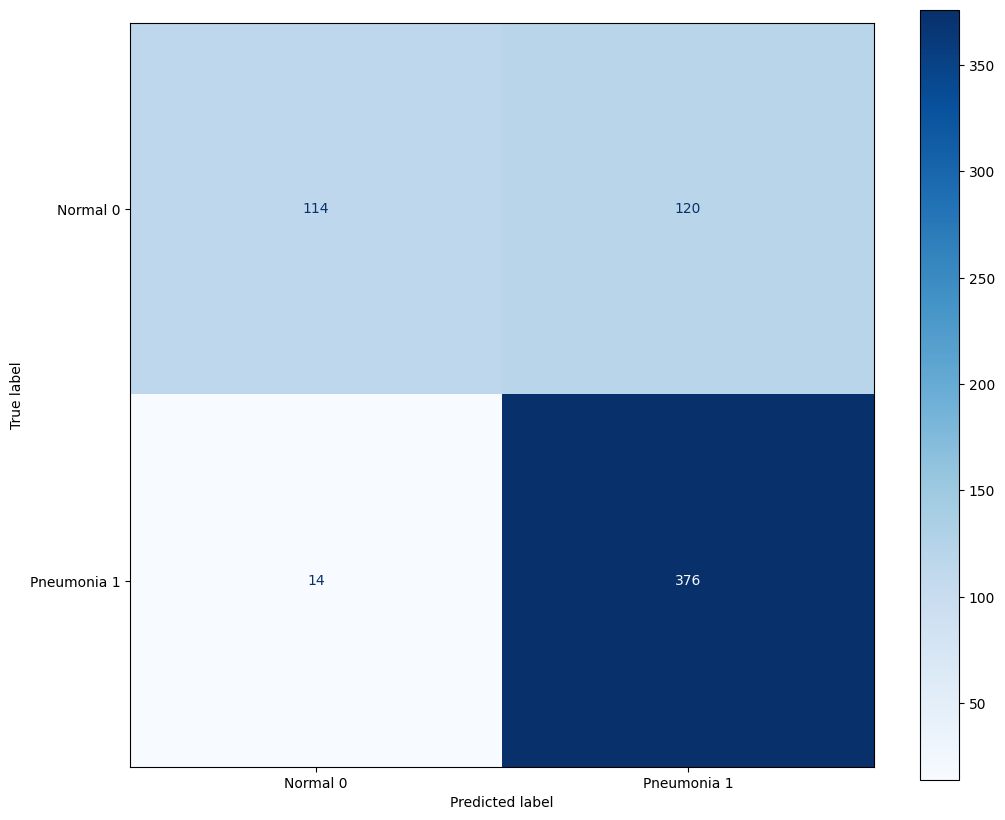

In [348]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

reg_model.evaluate(test_img_final, test_label_final)

# Calculate and plot the confusion matrix
# Convert predictions to binary labels using a threshold (e.g., 0.5)
y_pred_binary = (reg_model.predict(test_img_final) > 0.5).astype(int)
cnf_matrix = confusion_matrix(test_label_final, y_pred_binary)

display_labels = ['Normal 0', 'Pneumonia 1']

disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix, display_labels=display_labels)
disp.plot(cmap=plt.cm.Blues)

# **Evaluation**

In [349]:
reg_model.evaluate(valid_img_final, valid_label_final)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.4562 - recall: 1.0000


[0.4561644196510315, 1.0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.4562 - recall: 1.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


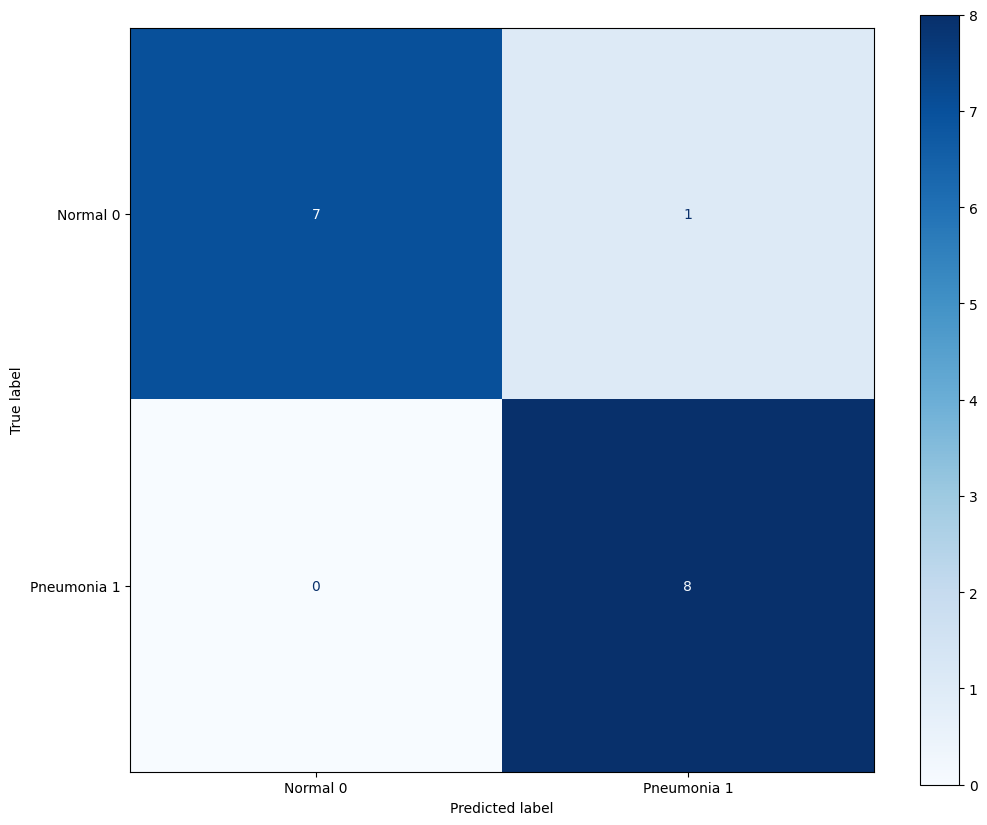

In [350]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

reg_model.evaluate(valid_img_final, valid_label_final)

# Calculate and plot the confusion matrix
# Convert predictions to binary labels using a threshold (e.g., 0.5)
y_pred_binary = (reg_model.predict(valid_img_final) > 0.5).astype(int)
cnf_matrix = confusion_matrix(valid_label_final, y_pred_binary)

display_labels = ['Normal 0', 'Pneumonia 1']

disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix, display_labels=display_labels)
disp.plot(cmap=plt.cm.Blues)

In [39]:
!pip install lime
!pip install scikit-image
import lime
from lime import lime_image
from skimage.io import imread
from skimage.segmentation import mark_boundaries
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=59f432cacbaae182f8f3862cf1d93ea74ff9c15b5eee330a2d88ebf7016475c8
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

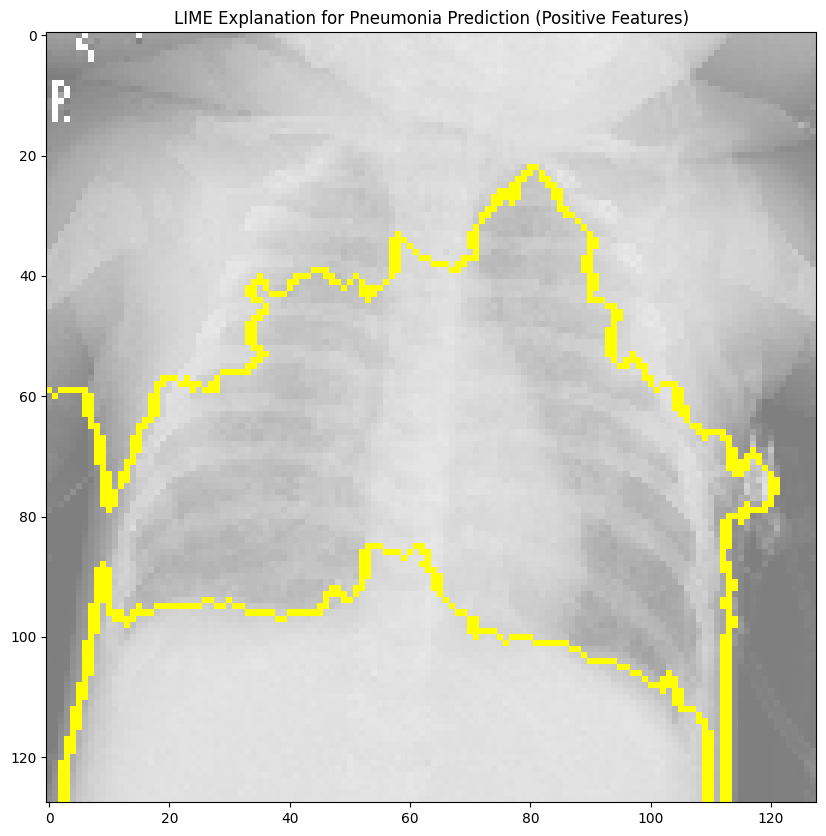

In [351]:
# prompt: use lime to show where model predicted the person had pneumonia

# Assuming reg_model and other necessary variables are defined as in the provided code.

import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np

img_path = '/content/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg'

# Load and preprocess the image
img = image.load_img(img_path, target_size=(128, 128))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x / 255.0  # Assuming your model expects input in the range [0, 1]

# Create a LimeImageExplainer
explainer = lime_image.LimeImageExplainer()

# Modified predict function to handle input reshaping
def predict_fn(images):
  reshaped_images = images.reshape(images.shape[0], -1)
  predictions = reg_model.predict(reshaped_images)
  return predictions

# Explain the prediction
explanation = explainer.explain_instance(x[0],
                                        predict_fn,
                                        top_labels=2,
                                        hide_color=0,
                                        num_samples=1000)

# Get the image with the superimposed explanation
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.title('LIME Explanation for Pneumonia Prediction (Positive Features)')
plt.show()
